In [1]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterator, *args, **kwargs):
        return iterator
import os, sys, glob, warnings, glob    
import numpy as np
import scipy as sp
from scipy import constants
from pylab import *
import joblib
import importlib
from importlib import reload
sys.path.append("/home/owhgabri/My_GitHub/MATHUSLA_JupyterNoteBooks/tracker")
sys.path.insert(1, "/home/owhgabri/My_GitHub/MATHUSLA_JupyterNoteBooks/tracker")
os.chdir('/home/owhgabri/My_GitHub/pyTracker')
print(os.getcwd())
print(joblib.__version__)

/home/owhgabri/My_GitHub/pyTracker
1.4.2


In [2]:
import scipy
import copy as cp

# ROOT
import ROOT as root

# Matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections, colors, transforms

%matplotlib inline
%config InlineBackend.figure_format='retina'
# %matplotlib widget

import pprint

Welcome to JupyROOT 6.26/14


In [3]:
import kalmanfilter as KF
import utilities as Util
import trackfinder as TF
import vertexfinder as VF
import datatypes
from datatypes import *

reload(TF)
reload(VF)
reload(Util)

<module 'utilities' from '/home/owhgabri/My_GitHub/MATHUSLA_JupyterNoteBooks/tracker/utilities.py'>

# Defining Useful Functions #

In [4]:
steel_height=3 # cm
Box_IP_Depth=8547 # cm   
c = 29.979


wall_floor1 = (7000,8633.2)
wall_floor2 = (7000,8551.6)
wallMid1 = 6896.6
wallMid2 = 6998.2
floorMid1 = 8550.8
floorMid2 = 8632.4

IP = (0,0,0)

y_bottoms = [8550, 8631.6]
z_fronts = [6895.8, 6997.4]
x_lims = (-1950, 1950)
thickness = 1.6

In [5]:
def SortByTime(points):
    """
    Sorts list hits by time
    A hit is of the form (x,y,z,t)
    """
    if len(points) <= 1:
        return points
    pivot = points[len(points) // 2]
    left = []
    middle = []
    right = []
    for point in points:
        if point[-1] < pivot[-1]:
            left.append(point)
        elif point[-1] > pivot[-1]:
            right.append(point)
        elif point[-1] == pivot[-1]:
            middle.append(point)
    return SortByTime(left) + middle + SortByTime(right)


def IP_track_cov(hit):
    """
    Construct the covariance of an "IP track" connecting from IP to a given hit
    Two points:
    IP: [0, 0, 0, t-dt], Hit: [x, y, z, t] 
    Returns the covariance of the tracklet
    Covariance will be of the form (x,y,z,Ax,Ay,Az)
    Refer to journal/report for explanation
    """
    x,y,z,t = (hit.x, hit.y, hit.z, hit.t)
    err = (hit.x_err, hit.y_err, hit.z_err, hit.t_err)
    dt= np.linalg.norm((x,y,z))/c
    dt3c2 = dt**3 * c**2
    
    # tracklet Jacobian #
    # dependent on the difinition of the tracklet #
    jac = np.array([[1, 0, 0, 0],
                    [0, 1, 0, 0],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1],
                    [1/dt - x**2/dt3c2, -x*y/dt3c2, -x*z/dt3c2, 0],
                    [-x*y/dt3c2, 1/dt - y**2/dt3c2, -z*y/dt3c2, 0],
                    [-x*z/dt3c2, -z*y/dt3c2, 1/dt - z**2/dt3c2, 0]])
    
    track_cov = jac @ np.diag(np.array(err)**2) @ jac.T
    return track_cov   


def MakeTracklet(hit):
    """
    Create a track from a hit in the floor/wall
    Assuming two points:
    IP: [0, 0, 0, t-dt], Hit: [x, y, z, t] 
    Returns a Track including covariance.
    No chi2, ind, hits, or hits_filtered included
    """
    x,y,z,t = (hit.x, hit.y, hit.z, hit.t)
    err = (hit.x_err, hit.y_err, hit.z_err, hit.t_err)
    cov = IP_track_cov(hit)
    dt = np.linalg.norm((x,y,z))/c
    Ax = x/dt; Ay = y/dt; Az = z/dt; At = 1
    # Ax = x/t; Ay = y/t; Az = z/t
    tracklet = datatypes.Track(x,y,z,t,Ax,Ay,Az,At,cov,0,0,[],[])
    return tracklet

    
def TrackMinimumTime(track, tracklet):
    """
    Get the time at which the distance between
    track1 and track2 is minimum
    track2 is the tracklet. It's velocities are parametrized by time
    """
    if track.Ay == 1: # Horizontal track
        Ax1 = track.Ax/track.At; Ay1 = 1/track.At; Az1 = track.Az/track.At
    elif track.Az == 1: # Vertical track
        Ax1 = track.Ax/track.At; Ay1 = track.Ay/track.At; Az1 = 1/track.At
    A1 = np.array((Ax1, Ay1, Az1))
    point1 = np.array((track.x0, track.y0, track.z0))
    
    Ax2 = tracklet.Ax; Ay2 = tracklet.Ay; Az2 = tracklet.Az
    A2 = np.array((Ax2, Ay2, Az2))
    point2 = np.array((tracklet.x0, tracklet.y0, tracklet.z0))
    
    A_diff = A1 - A2
    P_diff = point1 - point2
    return (-np.dot(A_diff, P_diff) + np.dot(A_diff, A1*track.t0 - A2*tracklet.t0))/np.dot(A_diff, A_diff)
        
    
def TrackDistance(track1, tracklet, minTime):
    """
    Get the distance between the track and tracklet at minTime
    """
    if track1.Ay == 1: # Horizontal track
        Ax1 = track1.Ax/track1.At; Ay1 = 1/track1.At; Az1 = track1.Az/track1.At
    elif track.Az == 1: # Vertical track
        Ax1 = track.Ax/track.At; Ay1 = track.Ay/track.At; Az1 = 1/track.At
    track1Point = np.array((track.x0 + Ax1*(minTime - track.t0), 
                           track.y0 + Ay1*(minTime - track.t0),
                           track.z0 + Az1*(minTime - track.t0)))
    trackletPoint = np.array((tracklet.x0 + tracklet.Ax*(minTime - tracklet.t0),
                             tracklet.y0 + tracklet.Ay*(minTime - tracklet.t0),
                             tracklet.z0 + tracklet.Az*(minTime - tracklet.t0)))
    return np.linalg.norm(track1Point - trackletPoint)


def TrackMidpoint(track1, tracklet, minTime):
    """
    Get the distance between the track and tracklet at minTime
    """
    if track1.Ay == 1: # Horizontal track
        Ax1 = track1.Ax/track1.At; Ay1 = 1/track1.At; Az1 = track1.Az/track1.At
    elif track.Az == 1: # Vertical track
        Ax1 = track1.Ax/track1.At; Ay1 = track1.Ay/track1.At; Az1 = 1/track1.At
    track1Point = np.array((track1.x0 + Ax1*(minTime - track1.t0), 
                           track1.y0 + Ay1*(minTime - track1.t0),
                           track1.z0 + Az1*(minTime - track1.t0)))
    trackletPoint = np.array((tracklet.x0 + tracklet.Ax*(minTime - tracklet.t0),
                             tracklet.y0 + tracklet.Ay*(minTime - tracklet.t0),
                             tracklet.z0 + tracklet.Az*(minTime - tracklet.t0)))
    return (track1Point + trackletPoint)/ 2

    
def TrackletProjectionPoint(tracklet, t):
    """
    Get the projection (x,y,z) of the tracklet at time t
    """
    return np.array((tracklet.x0 + tracklet.Ax*(t-tracklet.t0),
                    tracklet.y0 + tracklet.Ay*(t-tracklet.t0),
                    tracklet.z0 + tracklet.Az*(t-tracklet.t0)))
    

def TrackletProjectionCovariance(tracklet, t):
    """
    Get the projected covariance of the tracklet at time t
    Covariance for tracklets is of the form (x,y,z,Ax,Ay,Az)
    where A's are already with respect to time
    """
    x0,y0,z0,t0 = (tracklet.x0, tracklet.y0, tracklet.z0, tracklet.t0)
    jac = np.array([[1, 0, 0, t-t0, 0, 0],
                    [0, 1, 0, 0, t-t0, 0],
                    [0, 0, 1, 0, 0, t-t0]])
    return jac@track.cov@jac.T


def ProjectionTime(track, points, layer):
    """
    Takes a track and its SORTED list of points
    closest is true if you want to check in the closest wall/floor,
    false if you wanna check in the farther wall/floor
    Returns the time at which the track is 
    projected to enter the wall or floor
    Given point is (x,y,z,t)
    """
    if layer == 0:# Walls
        if track.Ay == 1: # Horizontal layer track 
            return track.At/track.Az*(wallMid1 - points[0][2]) + points[0][3]
        else: # Vertical layer track
            return track.At*(wallMid1 - points[0][2]) + points[0][3]
    elif layer == 1:
        if track.Ay == 1: # Horizontal layer track
            return track.At/track.Az*(wallMid2 - points[0][2]) + points[0][3]
        else: # Vertical layer track
            return track.At*(wallMid2 - points[0][2]) + points[0][3]
    elif layer == 2: # Floors
        if track.Ay == 1: # Horizontal layer track
            return track.At*(floorMid1 - points[0][1]) + points[0][3]
        else: # Vertical layer track
            return track.At/track.Ay*(floorMid1 - points[0][1]) + points[0][3]
    elif layer == 3: 
        if track.Ay == 1: # Horizontal layer track
            return track.At*(floorMid2 - points[0][1]) + points[0][3]
        else: # Vertical layer track
            return track.At/track.Ay*(floorMid2 - points[0][1]) + points[0][3]


def ProjectionPoint(track, points, t):
    """
    Returns where the track is projected to be at time t.
    points is the list of hits from the track sorted by time
    Returns an empty array if out of the detector
    """
    if track.Ay == 1: #Horizontal layer track
        xf = points[0][0] + track.Ax/track.At*(t - points[0][3])
        yf = points[0][1] + 1/track.At * (t - points[0][3])
        zf = points[0][2] + track.Az/track.At*(t - points[0][3])
    else: # Vertical layer track 
        xf = points[0][0] + track.Ax/track.At*(t - points[0][3])
        yf = points[0][1] + track.Ay/track.At * (t - points[0][3])
        zf = points[0][2] + 1/track.At*(t - points[0][3])
    return np.array((xf,yf,zf))


def ProjectionCovariance(track, points, t):
    """
    Returns the projected covariance of x,y,z at time t.
    covariance is x,z,t,Ax,Az,At if horizontal track, or 
    x,y,t,Ax,Ay,At if vertical track.
    points is sorted by time
    """
    dt = t - points[0][3]
    if track.Ay == 1: # Horizontal track
        Jac = np.array([[1, 0, -track.Ax/track.At, dt/track.At, 0, -track.Ax*dt/track.At**2],
                        [0, 0, -1/track.At, 0, 0, -dt/track.At**2],
                        [0, 1, -track.Az/track.At, 0, dt/track.At, -track.Az*dt/track.At**2]])
    elif track.Az == 1: # Vertical Track 
        Jac = np.array([[1, 0, -track.Ax/track.At, dt/track.At, 0, -track.Ax*dt/track.At**2],
                        [0, 1, -track.Ay/track.At, 0, dt/track.At, -track.Ay*dt/track.At**2],
                        [0, 0, -1/track.At, 0, 0, -dt/track.At**2]])    
    return Jac@track.cov@Jac.T


def GetChiSquared(track, tracklet):
    """
    Get the chi squared between a track and a tracklet
    """
    TrackPoints = SortByTime(track.hits_filtered)
    minTime = TrackMinimumTime(track, tracklet)
    midpoint = TrackMidpoint(track, tracklet, minTime)

    track_point_proj = ProjectionPoint(track, TrackPoints, minTime)
    tracklet_point_proj = TrackletProjectionPoint(tracklet, minTime)

    tracklet_cov_proj = TrackletProjectionCovariance(tracklet, minTime)
    track_cov_proj = ProjectionCovariance(track, TrackPoints, minTime)
    try:
        inv_tracklet_cov = np.linalg.inv(tracklet_cov_proj)
        inv_track_cov = np.linalg.inv(track_cov_proj)
    except:
        return None

    track_res = track_point_proj - midpoint
    tracklet_res = tracklet_point_proj - midpoint
    tracklet_chi2 = tracklet_res.T @ inv_tracklet_cov @ tracklet_res
    track_chi2 = track_res.T @ inv_track_cov @ track_res

    chi2 = tracklet_chi2 + track_chi2
    return chi2


def GetDistance(point1, point2):
    """
    Get the distance between two points (x,y,z)
    """
    return np.sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2 + (point1[2]-point2[2])**2)




# Background #

In [6]:
data_top_dir = f"/home/owhgabri/My_GitHub/data/Reconstruction/10xCosmicBackground"
pathList=[]

for rootFile, dirs, files in os.walk(data_top_dir):
    for filename in files:
        if ".pkl" in filename:
            pathList.append(os.path.join(rootFile, filename))


print(len(pathList))

187


## Chi2 and Distance Distribution (Track Level) ##

### Chi2 Distribution ###

In [7]:
chi2s = []
distances = []
times = []
for f in pathList:
    events=joblib.load(f)
    file_hits = events["hits"]
    file_tracks = events["tracks"]
    for i in range(len(file_hits)):
        hits= file_hits[i]
        tracks = file_tracks[i]
        wf_hits = []
        for hit in hits:
            if hit.layer < 4:
                wf_hits.append(hit)
        if len(wf_hits) == 0:
            continue
        for track in tracks:
            min_chi2 = None
            min_time = None
            min_distance = None
            for hit in wf_hits:
                TrackPoints = SortByTime(track.hits_filtered)
                tracklet = MakeTracklet(hit)
                cur_chi2 = GetChiSquared(track, tracklet)
                if cur_chi2 is not None and (min_chi2 is None or cur_chi2 < min_chi2):
                    min_chi2 = cur_chi2
                    min_time = TrackMinimumTime(track, tracklet)
                    min_distance = TrackDistance(track, tracklet, min_time)
            if min_chi2 is None:
                continue
            chi2_red = min_chi2
            if chi2_red > 0 and chi2_red < 500 and min_distance < 10000:
                chi2s.append(chi2_red)
                distances.append(min_distance)

[3.60936115]
[[inf]]


/home/owhgabri/environments/mathusla/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Text(0, 0.5, 'Reduced chi2')

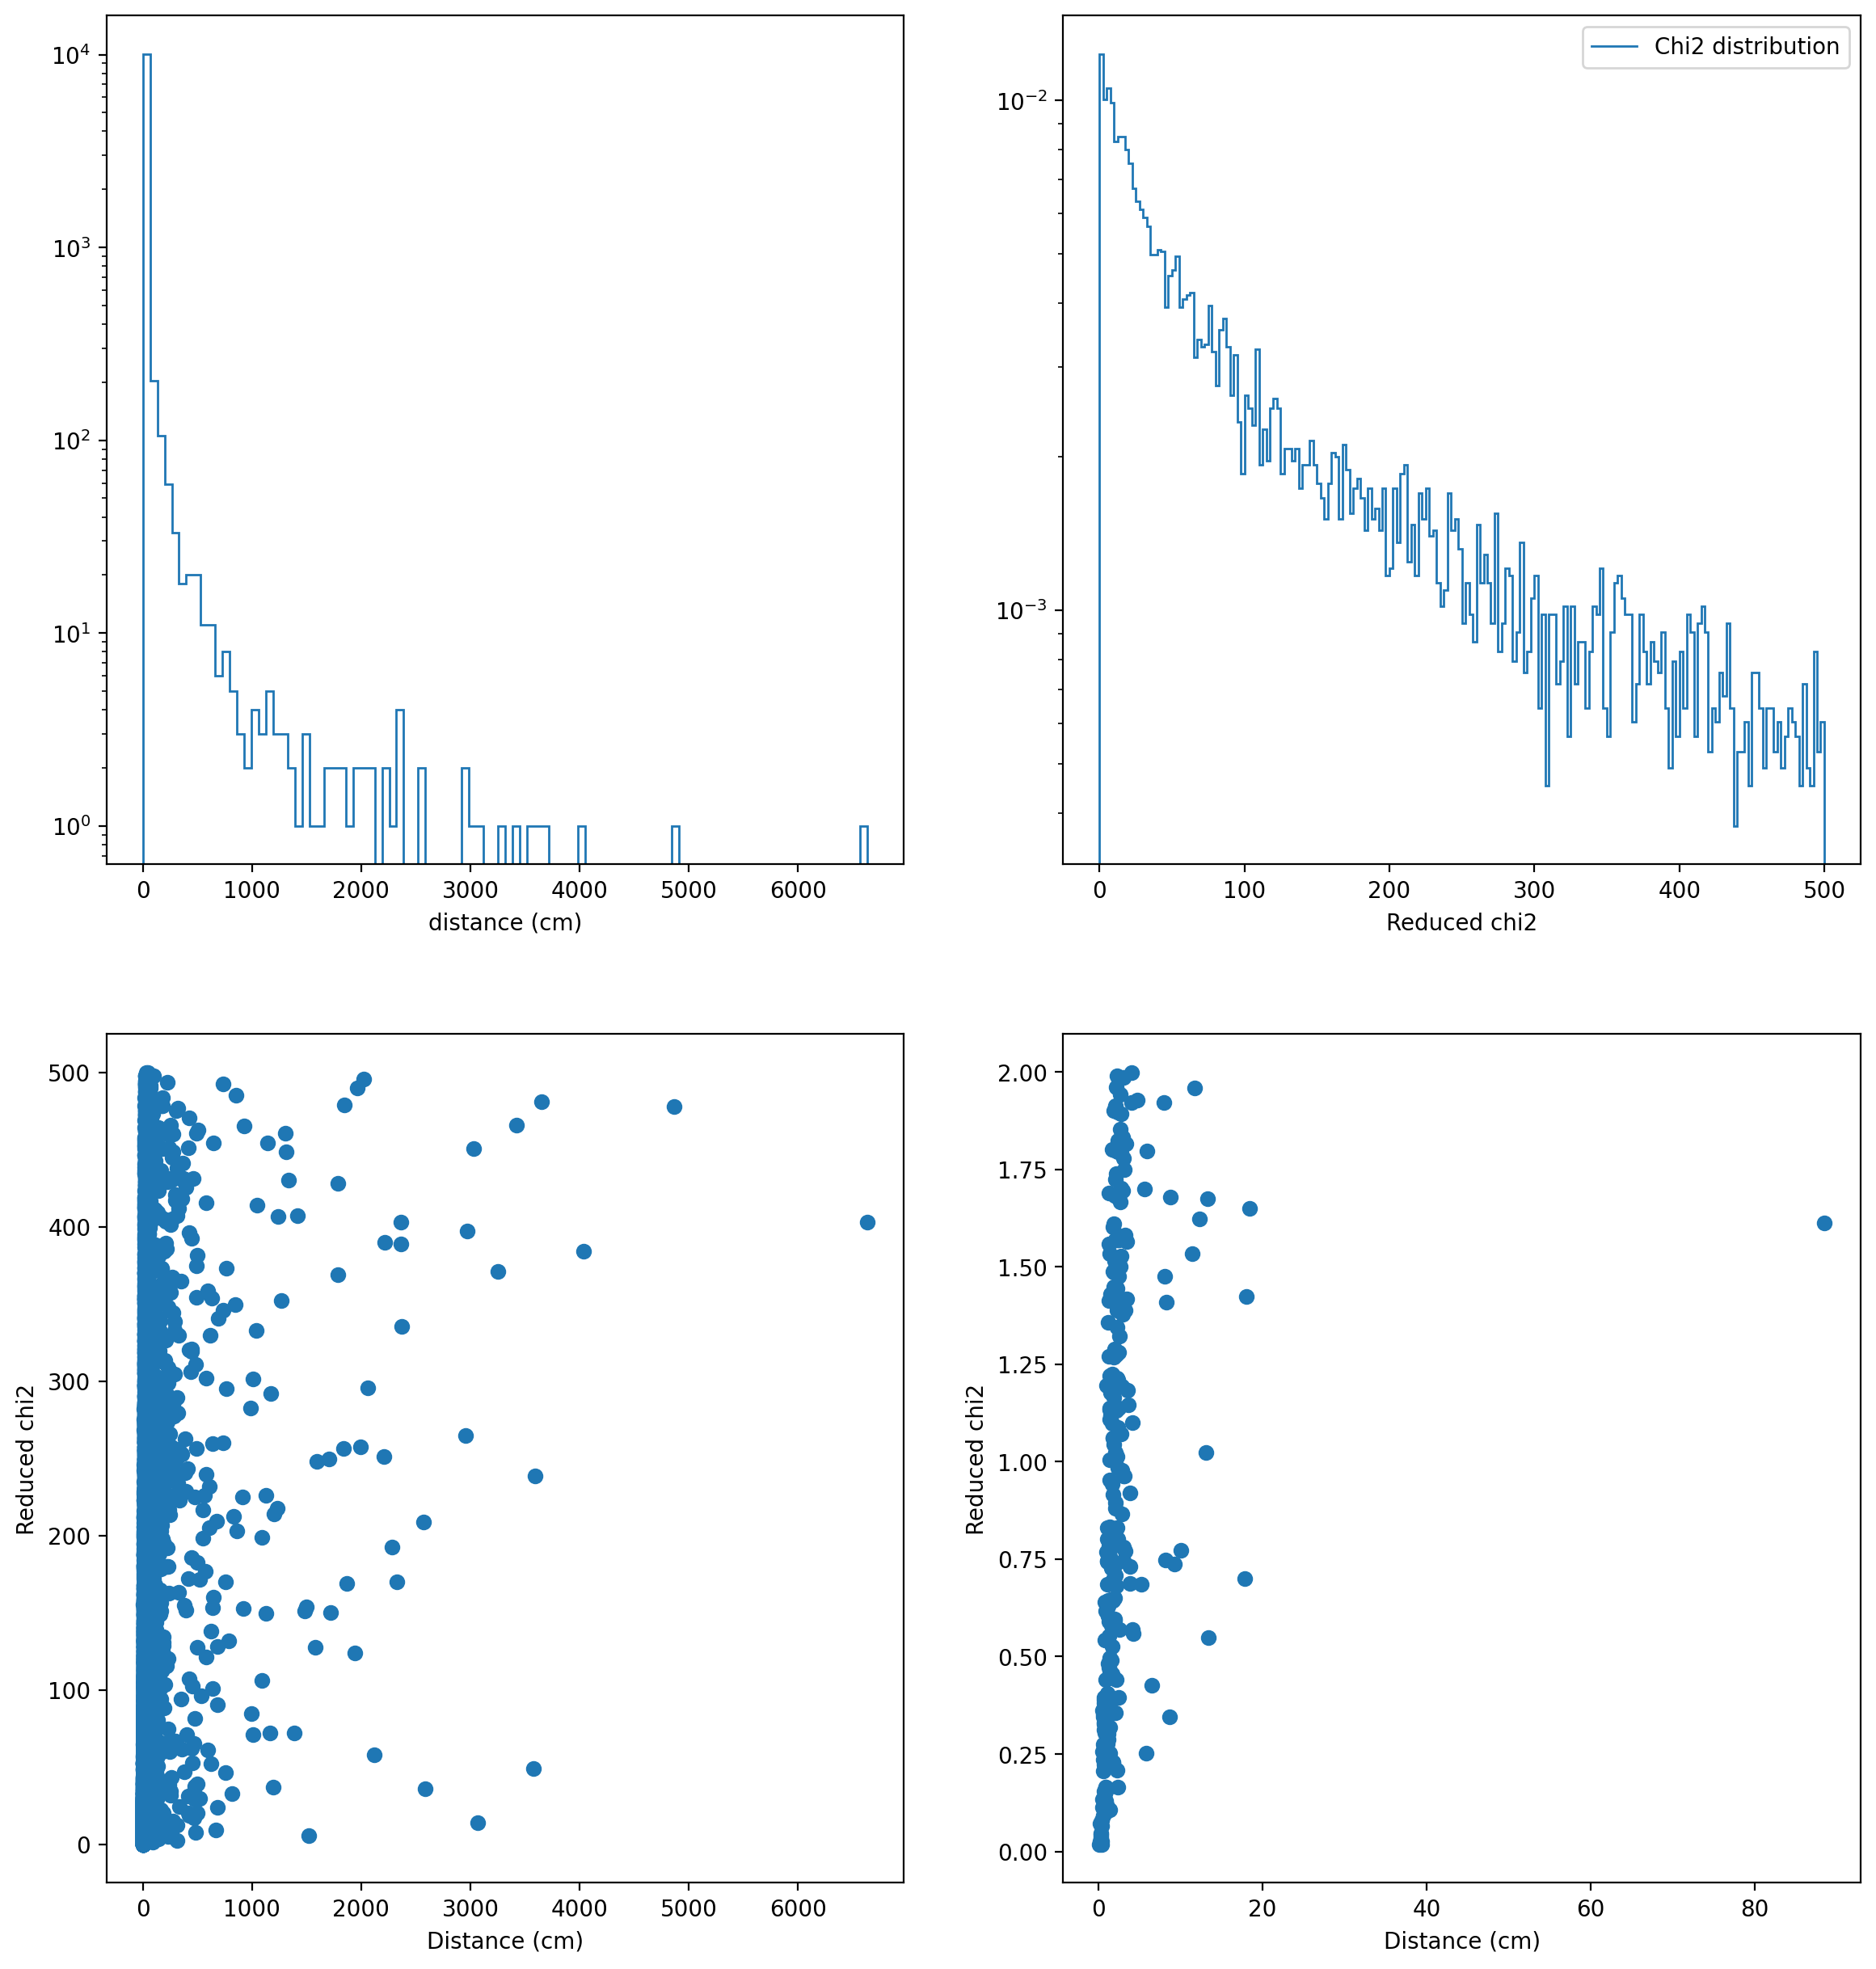

In [8]:
fig,axs=plt.subplots(2,2,figsize=(14,15))
axs=axs.flatten().tolist()

zoomedchis = []
zoomeddist = []
for i in range(len(chi2s)):
    if chi2s[i] < 2:
        zoomedchis.append(chi2s[i])
        zoomeddist.append(distances[i])

distancesCounts, distancesBins = np.histogram(distances, bins=100)
chi2Counts, chi2Bins = np.histogram(chi2s, bins=200)

binsize = chi2Bins[1] - chi2Bins[0]
chi2Counts = chi2Counts/(sum(chi2Counts)*binsize)

maxBin = 0
i=0
while chi2Bins[i] < 5:
    maxBin = i
    i+=1

popt, pcov = sp.optimize.curve_fit(lambda x,k: sp.stats.chi2.pdf(x,k,0,1), chi2Bins[:maxBin], chi2Counts[:maxBin], sigma=sqrt(chi2Counts[:maxBin]))
print(popt)
print(np.sqrt(pcov))

domain = np.arange(0, chi2Bins[-1], 0.1)
chi2_fit = sp.stats.chi2.pdf(domain, popt[0],0,1)
# chi2_fit = sp.stats.chi2.pdf(domain, 2,0,1)

axs[0].stairs(distancesCounts[:int(len(distancesCounts)/1)], distancesBins[:int(len(distancesCounts)/1) + 1])
axs[0].set_xlabel("distance (cm)")
axs[0].set_yscale("log")
axs[1].stairs(chi2Counts[:int(len(chi2Counts)/1)], chi2Bins[:int(len(chi2Counts)/1) + 1], label="Chi2 distribution")
# axs[1].plot(domain[:int(len(domain)/1)], chi2_fit[:int(len(domain)/1)], label="chi2 fit")
axs[1].set_yscale('log')
axs[1].legend()
axs[1].set_xlabel("Reduced chi2")
axs[2].scatter(distances, chi2s)
axs[2].set_xlabel("Distance (cm)")
axs[2].set_ylabel("Reduced chi2")
axs[3].scatter(zoomeddist, zoomedchis)
axs[3].set_xlabel("Distance (cm)")
axs[3].set_ylabel("Reduced chi2")

### Distance Distribution ###

In [9]:
distances = []
for f in pathList:
    events=joblib.load(f)
    file_hits = events["hits"]
    file_tracks = events["tracks"]
    for i in range(len(file_hits)):
        hits= file_hits[i]
        tracks = file_tracks[i]
        wf_hits = []
        for hit in hits:
            if hit.layer < 4:
                wf_hits.append(hit)
        if len(wf_hits) == 0:
            continue
        for track in tracks:
            min_hit = None
            min_dist = None
            min_time = None
            min_point = None
            for hit in wf_hits:
                tracklet = MakeTracklet(hit)
                t_shortest = TrackMinimumTime(track, tracklet)
                dist = TrackDistance(track, tracklet, t_shortest)
                if min_dist is None or dist < min_dist:
                    min_dist = dist
            if min_dist is None:
                continue
            if dist > 0 and dist < 5000:
                distances.append(min_dist)
                times.append(min_time)

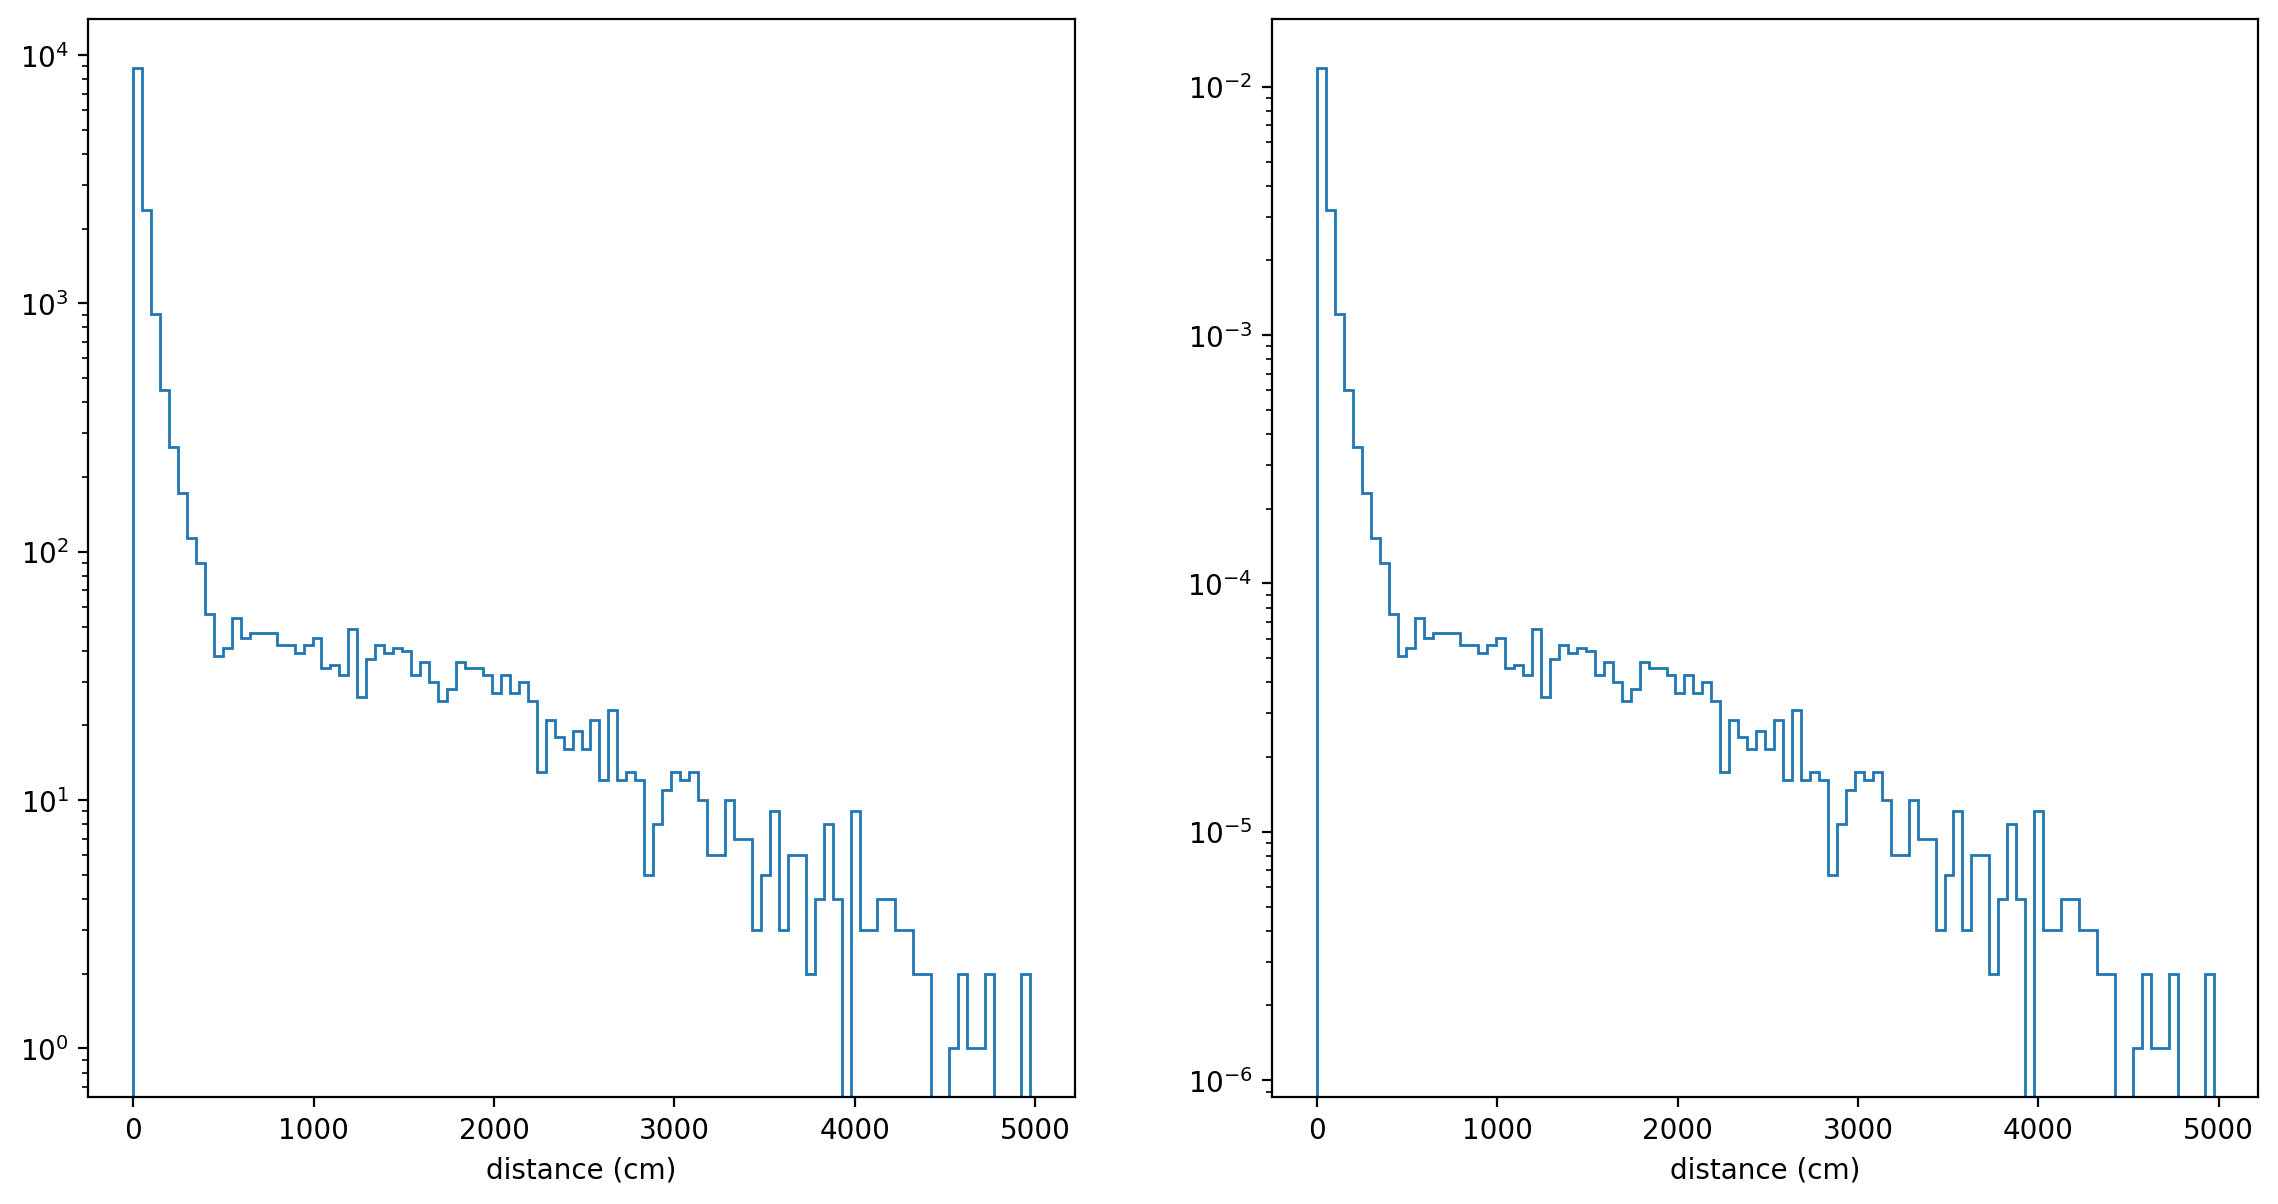

In [10]:
fig,axs=plt.subplots(1,2,figsize=(14,7))
axs=axs.flatten().tolist()

distancesCounts, distancesBins = np.histogram(distances, bins=100)

binsize = distancesBins[1] - distancesBins[0]
distancesNormed = distancesCounts/(sum(distancesCounts)*binsize)


axs[0].stairs(distancesCounts[:int(len(distancesCounts)/1)], distancesBins[:int(len(distancesCounts)/1) + 1])
axs[0].set_xlabel("distance (cm)")
axs[0].set_yscale("log")

axs[1].stairs(distancesNormed[:int(len(distancesCounts)/1)], distancesBins[:int(len(distancesCounts)/1) + 1])
axs[1].set_xlabel("distance (cm)")
axs[1].set_yscale("log")


## Chi2 and Distance Distribution (Event Level) ##

### Chi2 Distribution ### 

In [14]:
chi2s = []
distances = []
times = []
for f in pathList:
    events=joblib.load(f)
    file_hits = events["hits"]
    file_tracks = events["tracks"]
    file_vertices = events["vertices"]
    for i in range(len(file_hits)):
        hits= file_hits[i]
        tracks = file_tracks[i]
        vertices = file_vertices[i]
        if len(vertices) == 0:
            continue
        wf_hits = []
        for hit in hits:
            if hit.layer < 4:
                wf_hits.append(hit)
        if len(wf_hits) == 0:
            continue
        min_chi2 = None
        min_time = None
        min_distance = None
        for vertex in vertices:
            v_tracks = []
            for t_index in vertex.tracks:
                v_tracks.append(tracks[t_index])
            for track in v_tracks:
                for hit in wf_hits:
                    TrackPoints = SortByTime(track.hits_filtered)
                    tracklet = MakeTracklet(hit)
                    cur_chi2 = GetChiSquared(track, tracklet)
                    if cur_chi2 is not None and (min_chi2 is None or cur_chi2 < min_chi2):
                        min_chi2 = cur_chi2
                        min_time = TrackMinimumTime(track, tracklet)
                        min_distance = TrackDistance(track, tracklet, min_time)
        if min_chi2 is None:
            continue
        chi2_red = min_chi2
        if chi2_red > 0 and chi2_red < 200 and min_distance < 10000:
            chi2s.append(chi2_red)
            distances.append(min_distance)

[12.07746999]
[[2.47430222]]


Text(0, 0.5, 'Reduced chi2')

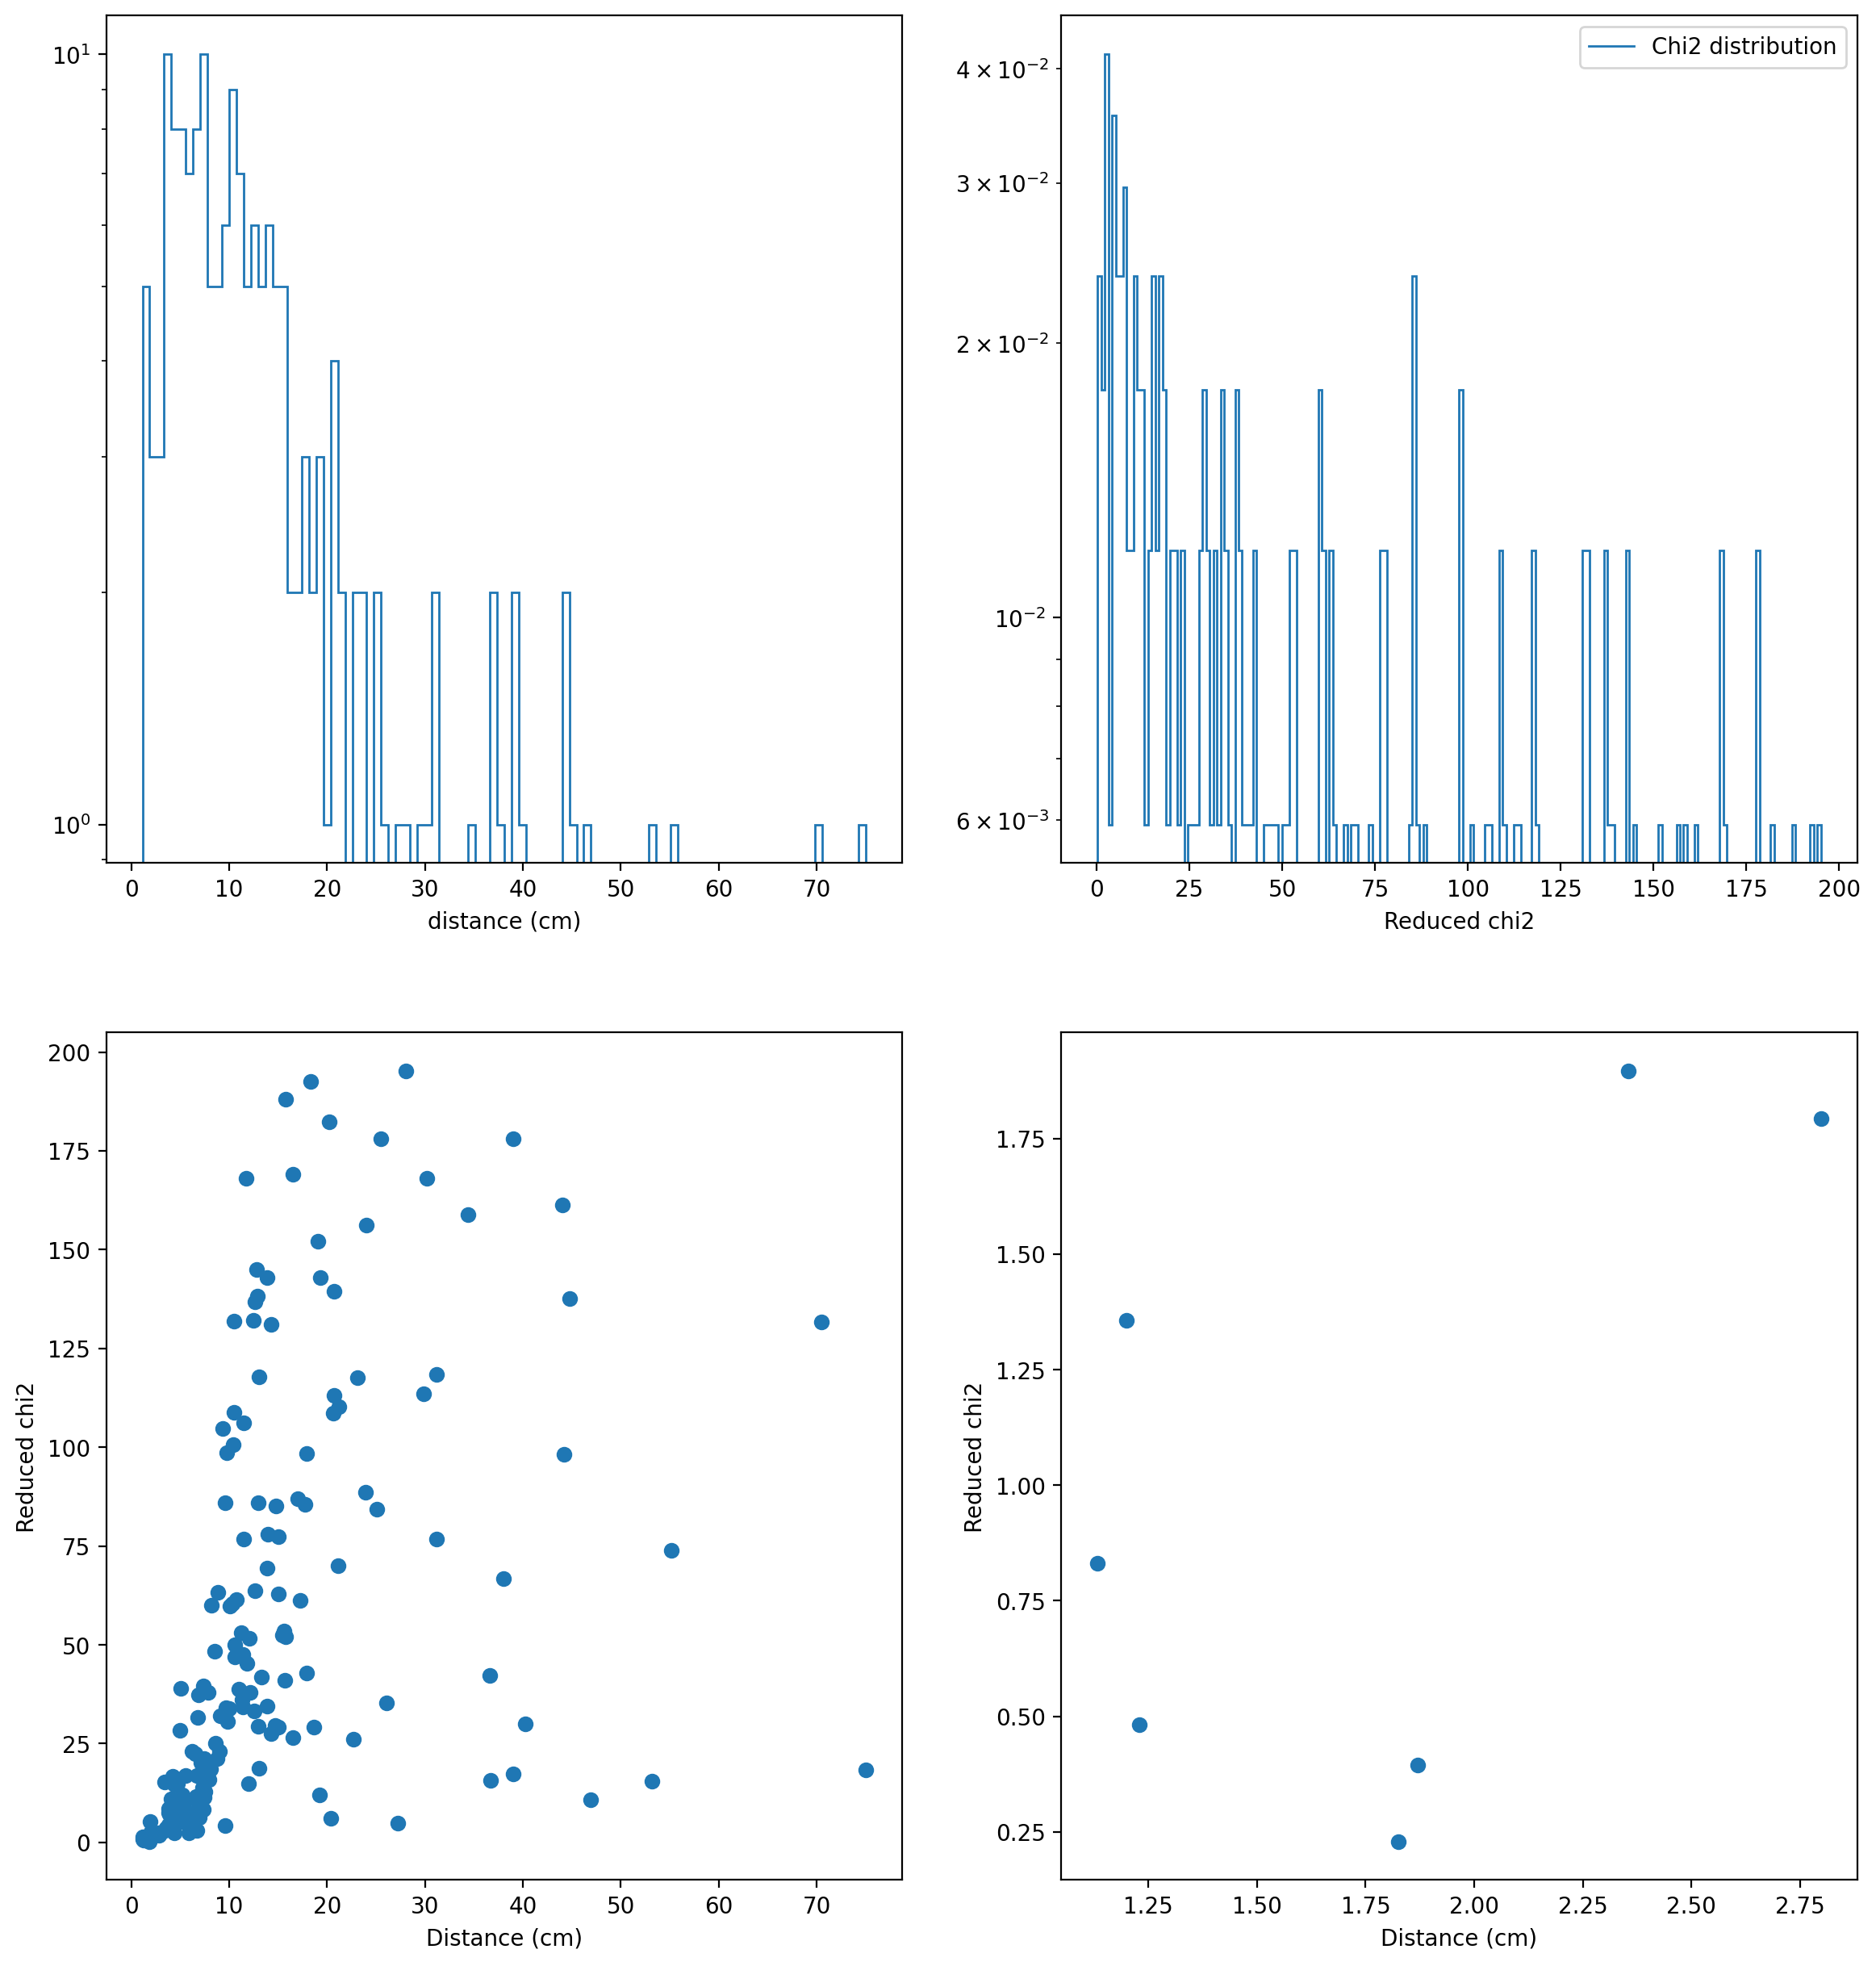

In [15]:
fig,axs=plt.subplots(2,2,figsize=(14,15))
axs=axs.flatten().tolist()

zoomedchis = []
zoomeddist = []
for i in range(len(chi2s)):
    if chi2s[i] < 2:
        zoomedchis.append(chi2s[i])
        zoomeddist.append(distances[i])

distancesCounts, distancesBins = np.histogram(distances, bins=100)
chi2Counts, chi2Bins = np.histogram(chi2s, bins=200)

binsize = chi2Bins[1] - chi2Bins[0]
chi2Counts = chi2Counts/(sum(chi2Counts)*binsize)

maxBin = 0
i=0
while chi2Bins[i] < 5:
    maxBin = i
    i+=1

popt, pcov = sp.optimize.curve_fit(lambda x,k: sp.stats.chi2.pdf(x,k,0,1), chi2Bins[:maxBin], chi2Counts[:maxBin], sigma=sqrt(chi2Counts[:maxBin]))
print(popt)
print(np.sqrt(pcov))

domain = np.arange(0, chi2Bins[-1], 0.1)
chi2_fit = sp.stats.chi2.pdf(domain, popt[0],0,1)
# chi2_fit = sp.stats.chi2.pdf(domain, 2,0,1)

axs[0].stairs(distancesCounts[:int(len(distancesCounts)/1)], distancesBins[:int(len(distancesCounts)/1) + 1])
axs[0].set_xlabel("distance (cm)")
axs[0].set_yscale("log")
axs[1].stairs(chi2Counts[:int(len(chi2Counts)/1)], chi2Bins[:int(len(chi2Counts)/1) + 1], label="Chi2 distribution")
# axs[1].plot(domain[:int(len(domain)/1)], chi2_fit[:int(len(domain)/1)], label="chi2 fit")
axs[1].set_yscale('log')
axs[1].legend()
axs[1].set_xlabel("Reduced chi2")
axs[2].scatter(distances, chi2s)
axs[2].set_xlabel("Distance (cm)")
axs[2].set_ylabel("Reduced chi2")
axs[3].scatter(zoomeddist, zoomedchis)
axs[3].set_xlabel("Distance (cm)")
axs[3].set_ylabel("Reduced chi2")

### Distance Distribution ###

In [7]:
distances = []
for f in pathList:
    events=joblib.load(f)
    file_hits = events["hits"]
    file_tracks = events["tracks"]
    file_vertices = events["vertices"]
    for i in range(len(file_hits)):
        hits= file_hits[i]
        tracks = file_tracks[i]
        vertices = file_vertices[i]
        if len(vertices) == 0:
            continue
        wf_hits = []
        for hit in hits:
            if hit.layer < 4:
                wf_hits.append(hit)
        if len(wf_hits) == 0:
            continue
        min_hit = None
        min_dist = None
        min_time = None
        min_point = None
        for vertex in vertices:
            v_tracks = []
            for t_index in vertex.tracks:
                v_tracks.append(tracks[t_index])
            for track in v_tracks:
                for hit in wf_hits:
                    tracklet = MakeTracklet(hit)
                    t_shortest = TrackMinimumTime(track, tracklet)
                    dist = TrackDistance(track, tracklet, t_shortest)
                    if min_dist is None or dist < min_dist:
                        min_dist = dist
        if min_dist is None:
            continue
        if dist > 0 and dist < 5000:
            distances.append(min_dist)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f1d3bea2280>>
Traceback (most recent call last):
  File "/home/owhgabri/environments/mathusla/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f1d3bea2280>>
Traceback (most recent call last):
  File "/home/owhgabri/environments/mathusla/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
fig,axs=plt.subplots(1,2,figsize=(14,7))
axs=axs.flatten().tolist()

distancesCounts, distancesBins = np.histogram(distances, bins=100)

binsize = distancesBins[1] - distancesBins[0]
distancesNormed = distancesCounts/(sum(distancesCounts)*binsize)


axs[0].stairs(distancesCounts[:int(len(distancesCounts)/1)], distancesBins[:int(len(distancesCounts)/1) + 1])
axs[0].set_xlabel("distance (cm)")
axs[0].set_yscale("log")

axs[1].stairs(distancesNormed[:int(len(distancesCounts)/1)], distancesBins[:int(len(distancesCounts)/1) + 1])
axs[1].set_xlabel("distance (cm)")
axs[1].set_yscale("log")


## Implementing Veto: Track Veto Efficiency ##

### Survival Rate for given Distance Values ###

In [9]:
distances = []
nTracks = 0
for f in pathList:
    events=joblib.load(f)
    file_hits = events["hits"]
    file_tracks = events["tracks"]
    for i in range(len(file_hits)):
        hits= file_hits[i]
        tracks = file_tracks[i]
        nTracks += len(tracks)
        wf_hits = []
        for hit in hits:
            if hit.layer < 4:
                wf_hits.append(hit)
        if len(wf_hits) == 0:
            continue
        for track in tracks:
            min_hit = None
            min_dist = None
            min_time = None
            min_point = None
            for hit in wf_hits:
                tracklet = MakeTracklet(hit)
                t_shortest = TrackMinimumTime(track, tracklet)
                dist = TrackDistance(track, tracklet, t_shortest)
                if min_dist is None or dist < min_dist:
                    min_dist = dist
            if min_dist is None:
                continue
            if dist > 0 and dist < 5000:
                distances.append(min_dist)

Fraction surviving after dist=100 cut: 0.4604413515093956
Fraction surviving after dist=200 cut: 0.38563305864641695
Fraction surviving after dist=300 cut: 0.3692928505368629
Fraction surviving after dist=500 cut: 0.3561626223960386


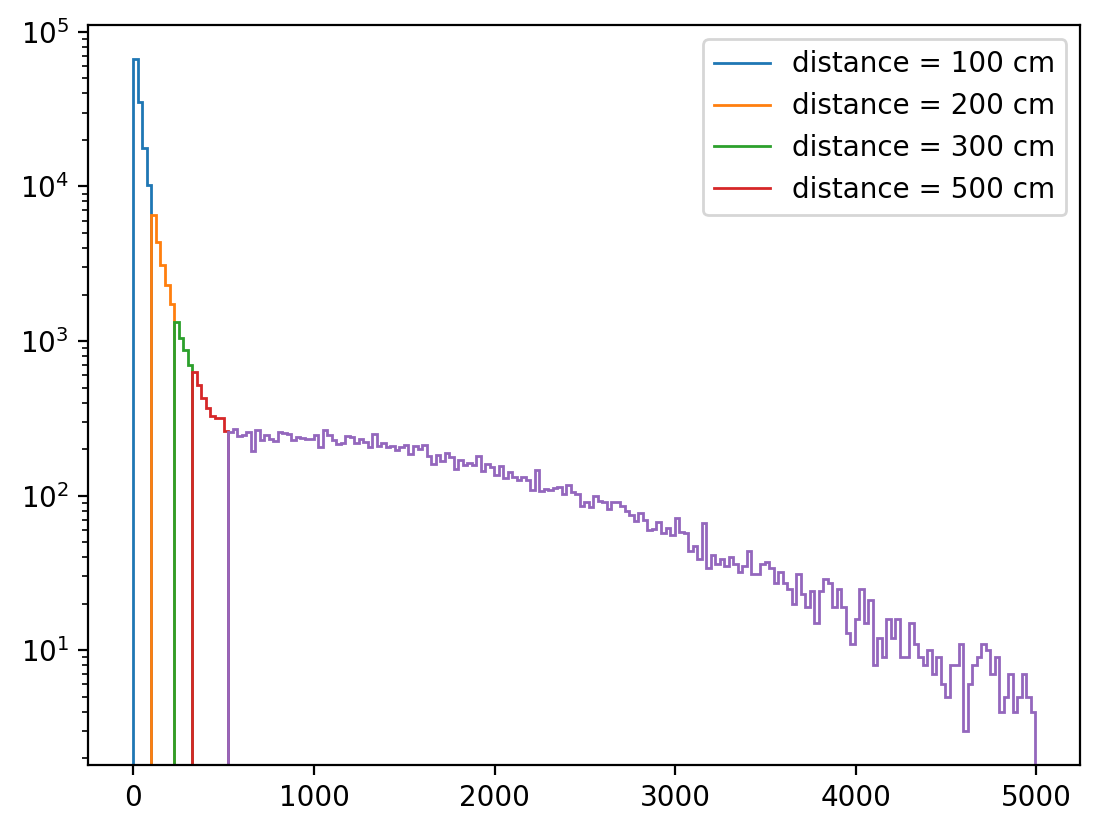

In [10]:
d_1Counts = []
d_2Counts = []
d_3Counts = []
d_5Counts = []
d_restCounts = []

dCounts, dBins = np.histogram(distances, bins=200)

i=0
start_1 = 0
while dBins[i] < 100:
    d_1Counts.append(dCounts[i])
    i+=1
n_1Bins = dBins[start_1:start_1 + len(d_1Counts)+1]
start_2 = i
while dBins[i] < 200:
    d_2Counts.append(dCounts[i])
    i+=1
n_2Bins = dBins[start_2:start_2 + len(d_2Counts)+1]
start_3 = i
while dBins[i] < 300:
    d_3Counts.append(dCounts[i])
    i+=1
n_3Bins = dBins[start_3:start_3 + len(d_3Counts)+1]
start_5 = i
while dBins[i] < 500:
    d_5Counts.append(dCounts[i])
    i+=1
n_5Bins = dBins[start_5:start_5 + len(d_5Counts)+1]
start_rest = i
while i < len(dBins) - 1:
    d_restCounts.append(dCounts[i])
    i+=1
n_rest = dBins[start_rest:start_rest + len(d_restCounts)+1]
frac_1 = 1 - sum(d_1Counts)/nTracks; frac_2 = 1 - (sum(d_1Counts) + sum(d_2Counts))/nTracks
frac_3 = 1 - (sum(d_1Counts) + sum(d_2Counts) + sum(d_3Counts))/nTracks
frac_5 = 1 - (sum(d_1Counts) + sum(d_2Counts) + sum(d_3Counts) + sum(d_5Counts))/nTracks
print("Fraction surviving after dist=100 cut:", frac_1)
print("Fraction surviving after dist=200 cut:", frac_2)
print("Fraction surviving after dist=300 cut:", frac_3)
print("Fraction surviving after dist=500 cut:", frac_5)
plt.stairs(d_1Counts, n_1Bins, label="distance = 100 cm")
plt.stairs(d_2Counts, n_2Bins, label="distance = 200 cm")
plt.stairs(d_3Counts, n_3Bins, label="distance = 300 cm")
plt.stairs(d_5Counts, n_5Bins, label="distance = 500 cm")
plt.stairs(d_restCounts, n_rest)
plt.yscale('log')
plt.legend()

## Implementing Veto: Event Veto Efficiency ##

### Survival Rate for given Distance Values ###

In [14]:
distances = []
nEvents = 0
for f in pathList:
    events=joblib.load(f)
    file_hits = events["hits"]
    file_tracks = events["tracks"]
    file_vertices = events["vertices"]
    for i in range(len(file_hits)):
        hits= file_hits[i]
        tracks = file_tracks[i]
        vertices = file_vertices[i]
        if len(vertices) == 0:
            continue
        nEvents += 1
        wf_hits = []
        for hit in hits:
            if hit.layer < 4:
                wf_hits.append(hit)
        if len(wf_hits) == 0:
            continue
        min_hit = None
        min_dist = None
        min_time = None
        min_point = None
        for vertex in vertices:
            v_tracks = []
            for t_index in vertex.tracks:
                v_tracks.append(tracks[t_index])
            for track in v_tracks:
                for hit in wf_hits:
                    tracklet = MakeTracklet(hit)
                    t_shortest = TrackMinimumTime(track, tracklet)
                    dist = TrackDistance(track, tracklet, t_shortest)
                    if min_dist is None or dist < min_dist:
                        min_dist = dist
        if min_dist is None:
            continue
        if dist > 0 and dist < 5000:
            distances.append(min_dist)
print("Number of events with at least one vertex:", nEvents)

Fraction surviving after dist=100 cut: 0.4050461204557786
Fraction surviving after dist=200 cut: 0.37791644058600105
Fraction surviving after dist=300 cut: 0.3695062398263701
Fraction surviving after dist=500 cut: 0.3589256646771568


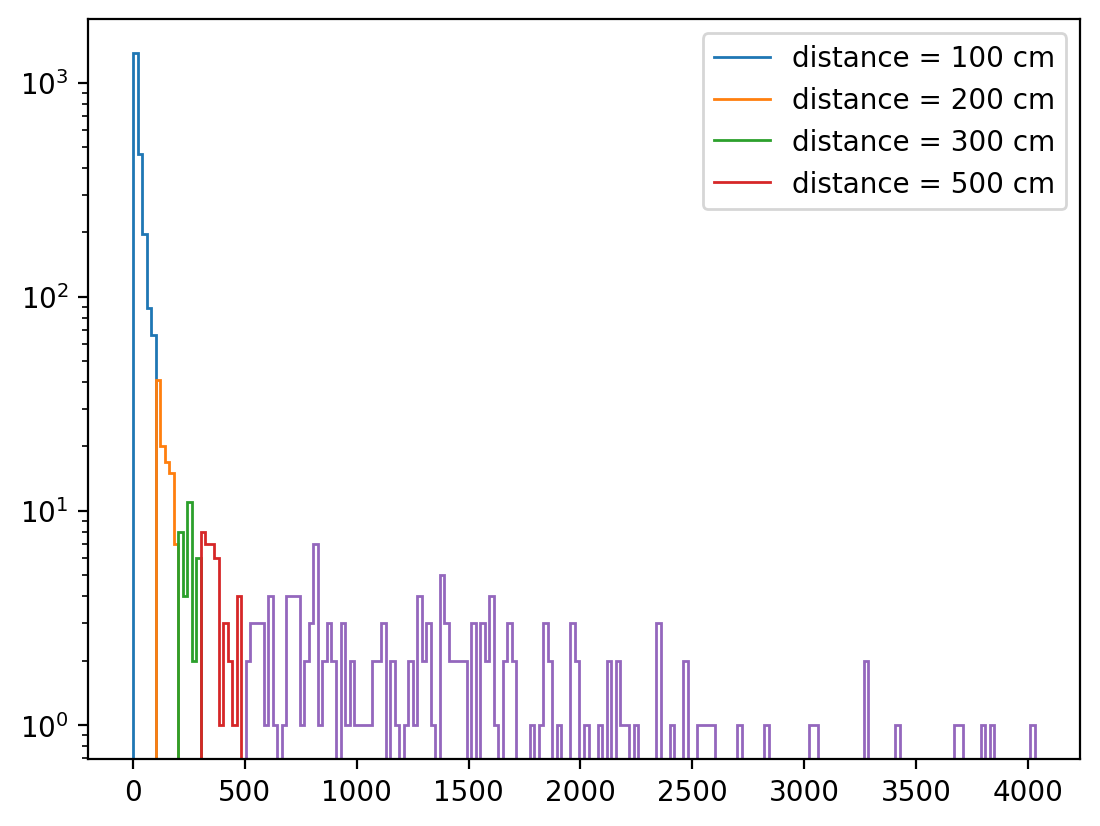

In [15]:
d_1Counts = []
d_2Counts = []
d_3Counts = []
d_5Counts = []
d_restCounts = []

dCounts, dBins = np.histogram(distances, bins=200)

i=0
start_1 = 0
while dBins[i] < 100:
    d_1Counts.append(dCounts[i])
    i+=1
n_1Bins = dBins[start_1:start_1 + len(d_1Counts)+1]
start_2 = i
while dBins[i] < 200:
    d_2Counts.append(dCounts[i])
    i+=1
n_2Bins = dBins[start_2:start_2 + len(d_2Counts)+1]
start_3 = i
while dBins[i] < 300:
    d_3Counts.append(dCounts[i])
    i+=1
n_3Bins = dBins[start_3:start_3 + len(d_3Counts)+1]
start_5 = i
while dBins[i] < 500:
    d_5Counts.append(dCounts[i])
    i+=1
n_5Bins = dBins[start_5:start_5 + len(d_5Counts)+1]
start_rest = i
while i < len(dBins) - 1:
    d_restCounts.append(dCounts[i])
    i+=1
n_rest = dBins[start_rest:start_rest + len(d_restCounts)+1]
frac_1 = 1 - sum(d_1Counts)/nEvents; frac_2 = 1 - (sum(d_1Counts) + sum(d_2Counts))/nEvents
frac_3 = 1 - (sum(d_1Counts) + sum(d_2Counts) + sum(d_3Counts))/nEvents
frac_5 = 1 - (sum(d_1Counts) + sum(d_2Counts) + sum(d_3Counts) + sum(d_5Counts))/nEvents
print("Fraction surviving after dist=100 cut:", frac_1)
print("Fraction surviving after dist=200 cut:", frac_2)
print("Fraction surviving after dist=300 cut:", frac_3)
print("Fraction surviving after dist=500 cut:", frac_5)
plt.stairs(d_1Counts, n_1Bins, label="distance = 100 cm")
plt.stairs(d_2Counts, n_2Bins, label="distance = 200 cm")
plt.stairs(d_3Counts, n_3Bins, label="distance = 300 cm")
plt.stairs(d_5Counts, n_5Bins, label="distance = 500 cm")
plt.stairs(d_restCounts, n_rest)
plt.yscale('log')
plt.legend()

# Signal #

In [25]:
data_top_dir = f"/home/owhgabri/My_GitHub/data/Reconstruction/LLP"
pathList=[]

for rootFile, dirs, files in os.walk(data_top_dir):
    for filename in files:
        if ".pkl" in filename:
            pathList.append(os.path.join(rootFile, filename))


print(len(pathList))

5


## Chi2 and Distance Distribution (Track Level) ##

### Chi2 Distribution ###

In [26]:
chi2s = []
distances = []
times = []
for f in pathList:
    events=joblib.load(f)
    file_hits = events["hits"]
    file_tracks = events["tracks"]
    for i in range(len(file_hits)):
        hits= file_hits[i]
        tracks = file_tracks[i]
        wf_hits = []
        for hit in hits:
            if hit.layer < 4:
                wf_hits.append(hit)
        if len(wf_hits) == 0:
            continue
        for track in tracks:
            min_chi2 = None
            min_time = None
            min_distance = None
            for hit in wf_hits:
                TrackPoints = SortByTime(track.hits_filtered)
                tracklet = MakeTracklet(hit)
                cur_chi2 = GetChiSquared(track, tracklet)
                if cur_chi2 is not None and (min_chi2 is None or cur_chi2 < min_chi2):
                    min_chi2 = cur_chi2
                    min_time = TrackMinimumTime(track, tracklet)
                    min_distance = TrackDistance(track, tracklet, min_time)
            if min_chi2 is None:
                continue
            chi2_red = min_chi2
            if chi2_red > 0 and chi2_red < 500 and min_distance < 10000:
                chi2s.append(chi2_red)
                distances.append(min_distance)

[4.37303197]
[[inf]]


Text(0, 0.5, 'Reduced chi2')

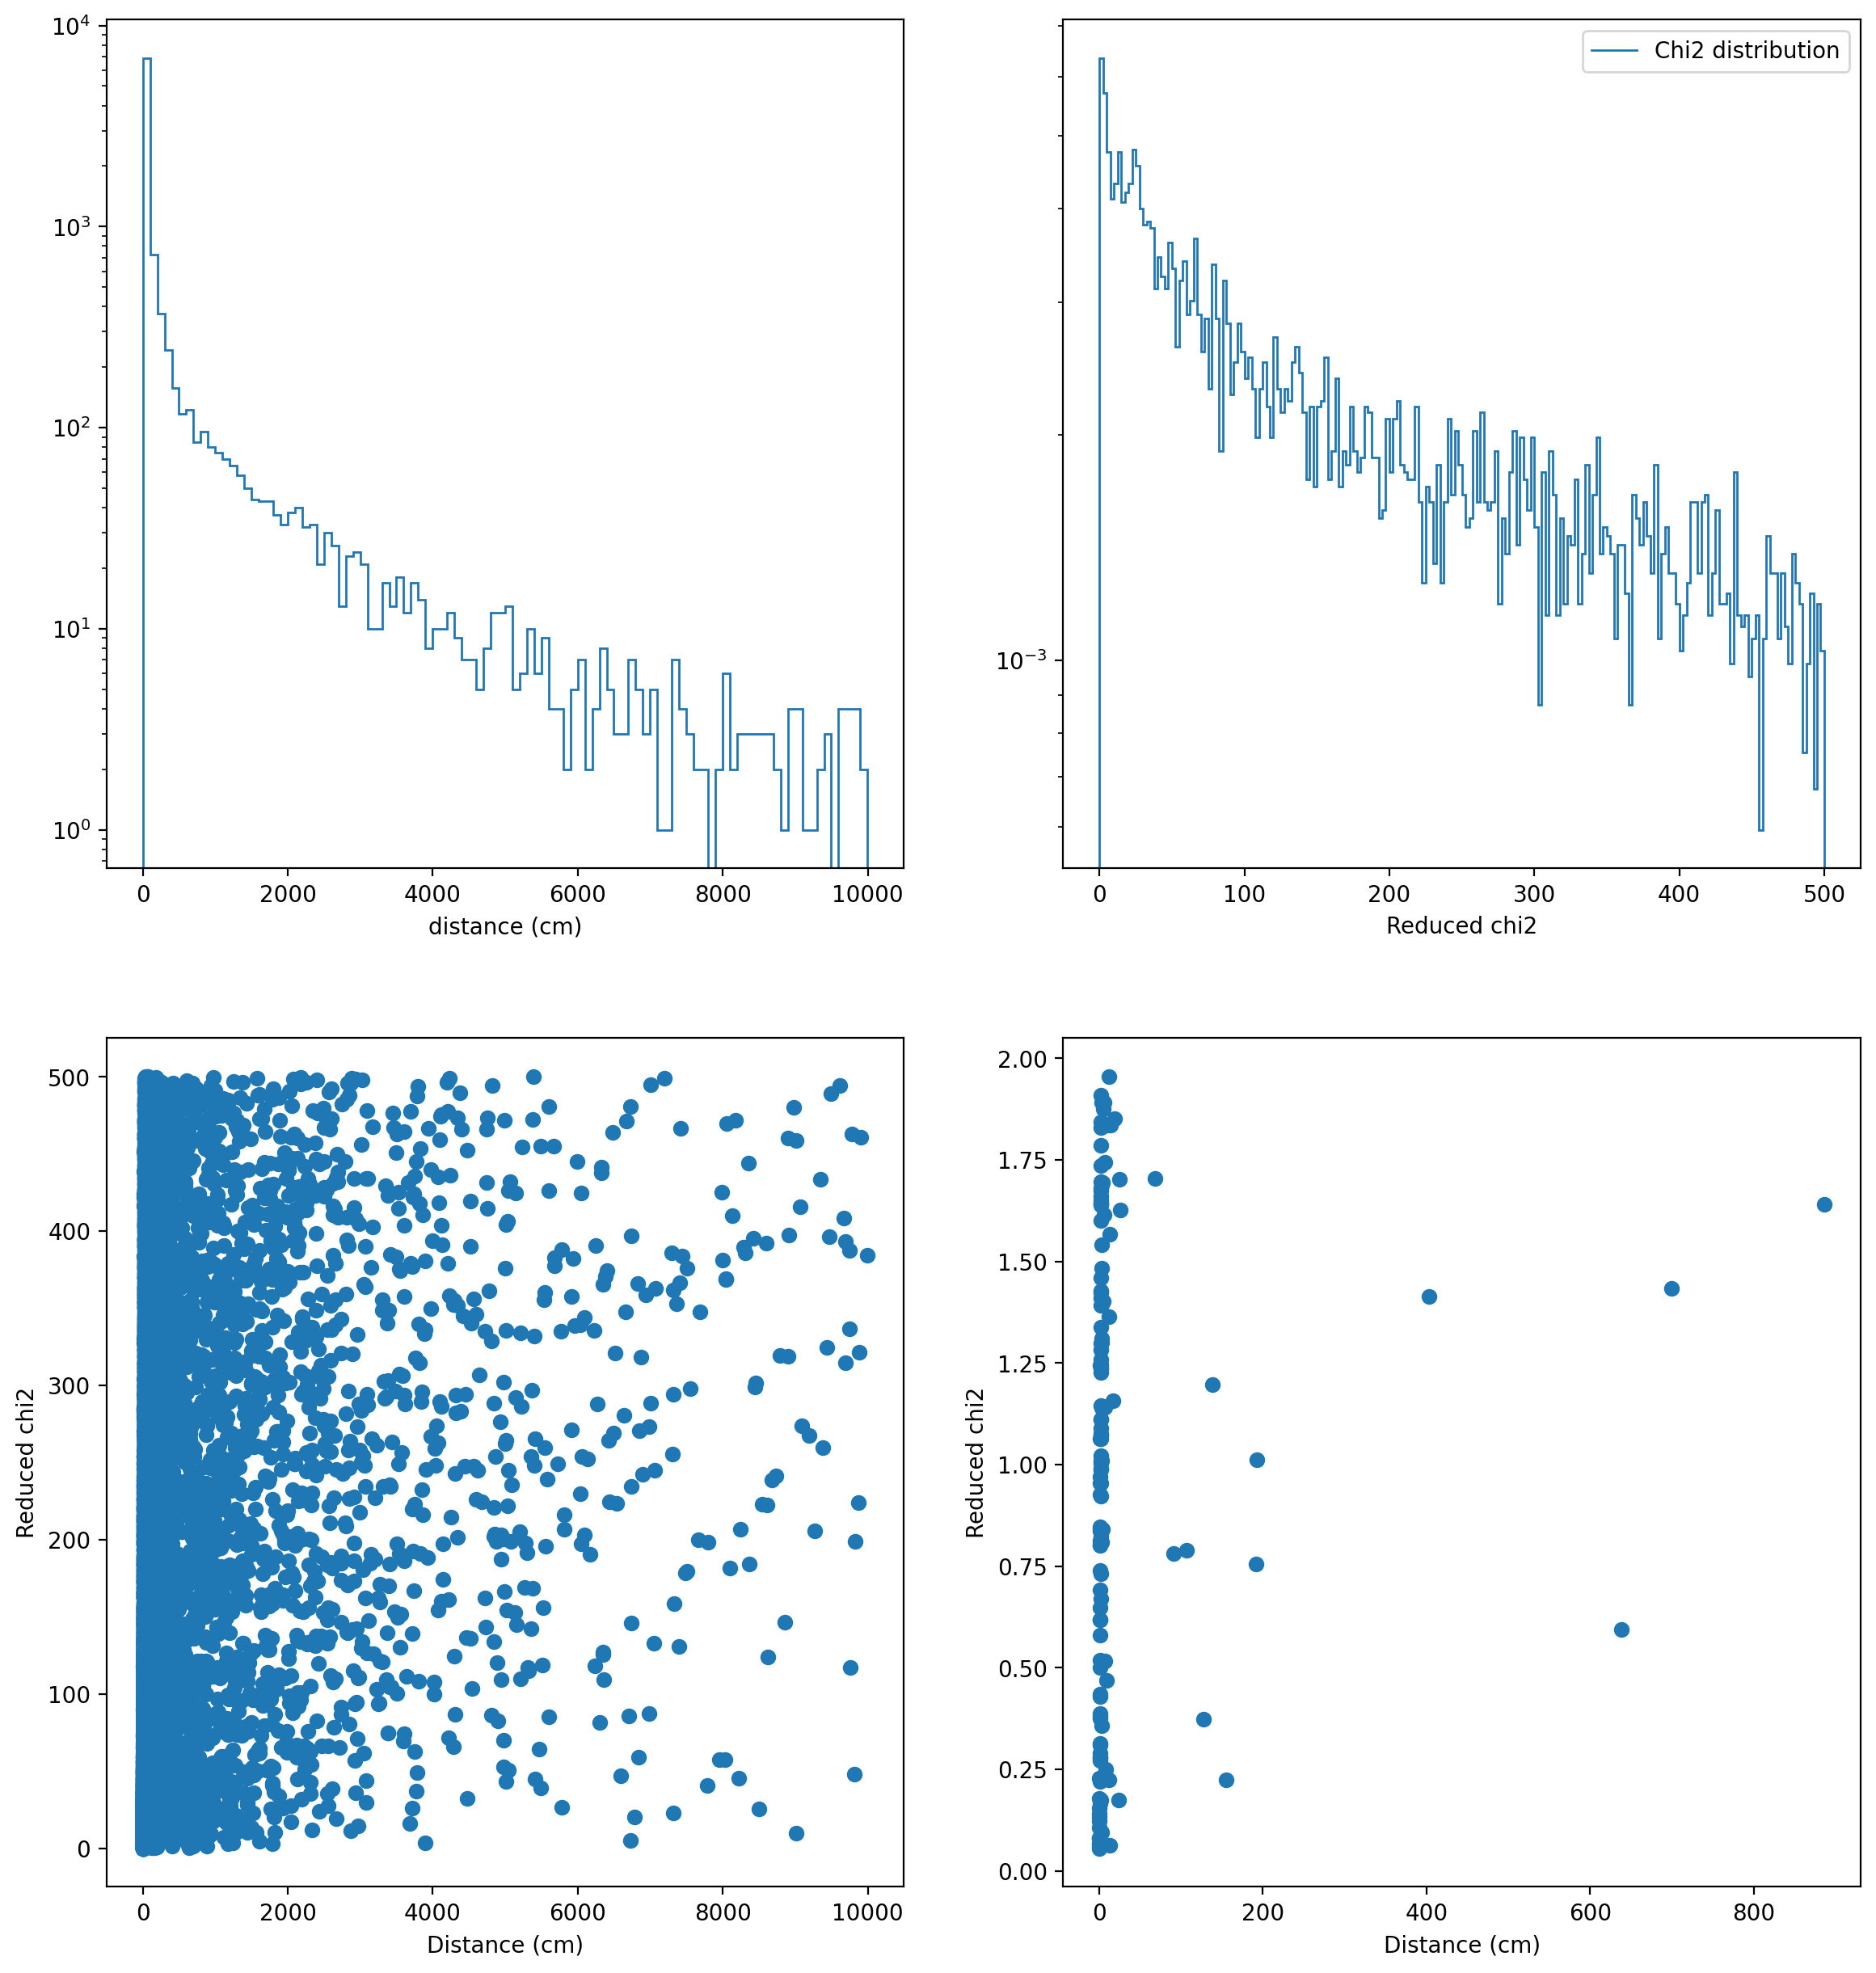

In [27]:
fig,axs=plt.subplots(2,2,figsize=(14,15))
axs=axs.flatten().tolist()

zoomedchis = []
zoomeddist = []
for i in range(len(chi2s)):
    if chi2s[i] < 2:
        zoomedchis.append(chi2s[i])
        zoomeddist.append(distances[i])

distancesCounts, distancesBins = np.histogram(distances, bins=100)
chi2Counts, chi2Bins = np.histogram(chi2s, bins=200)

binsize = chi2Bins[1] - chi2Bins[0]
chi2Counts = chi2Counts/(sum(chi2Counts)*binsize)

maxBin = 0
i=0
while chi2Bins[i] < 5:
    maxBin = i
    i+=1

popt, pcov = sp.optimize.curve_fit(lambda x,k: sp.stats.chi2.pdf(x,k,0,1), chi2Bins[:maxBin], chi2Counts[:maxBin], sigma=sqrt(chi2Counts[:maxBin]))
print(popt)
print(np.sqrt(pcov))

domain = np.arange(0, chi2Bins[-1], 0.1)
chi2_fit = sp.stats.chi2.pdf(domain, popt[0],0,1)
# chi2_fit = sp.stats.chi2.pdf(domain, 2,0,1)

axs[0].stairs(distancesCounts[:int(len(distancesCounts)/1)], distancesBins[:int(len(distancesCounts)/1) + 1])
axs[0].set_xlabel("distance (cm)")
axs[0].set_yscale("log")
axs[1].stairs(chi2Counts[:int(len(chi2Counts)/1)], chi2Bins[:int(len(chi2Counts)/1) + 1], label="Chi2 distribution")
# axs[1].plot(domain[:int(len(domain)/1)], chi2_fit[:int(len(domain)/1)], label="chi2 fit")
axs[1].set_yscale('log')
axs[1].legend()
axs[1].set_xlabel("Reduced chi2")
axs[2].scatter(distances, chi2s)
axs[2].set_xlabel("Distance (cm)")
axs[2].set_ylabel("Reduced chi2")
axs[3].scatter(zoomeddist, zoomedchis)
axs[3].set_xlabel("Distance (cm)")
axs[3].set_ylabel("Reduced chi2")

### Distance Distribution ###

In [28]:
distances = []
for f in pathList:
    events=joblib.load(f)
    file_hits = events["hits"]
    file_tracks = events["tracks"]
    for i in range(len(file_hits)):
        hits= file_hits[i]
        tracks = file_tracks[i]
        wf_hits = []
        for hit in hits:
            if hit.layer < 4:
                wf_hits.append(hit)
        if len(wf_hits) == 0:
            continue
        for track in tracks:
            min_hit = None
            min_dist = None
            min_time = None
            min_point = None
            for hit in wf_hits:
                tracklet = MakeTracklet(hit)
                t_shortest = TrackMinimumTime(track, tracklet)
                dist = TrackDistance(track, tracklet, t_shortest)
                if min_dist is None or dist < min_dist:
                    min_dist = dist
            if min_dist is None:
                continue
            if dist > 0 and dist < 5000:
                distances.append(min_dist)
                times.append(min_time)

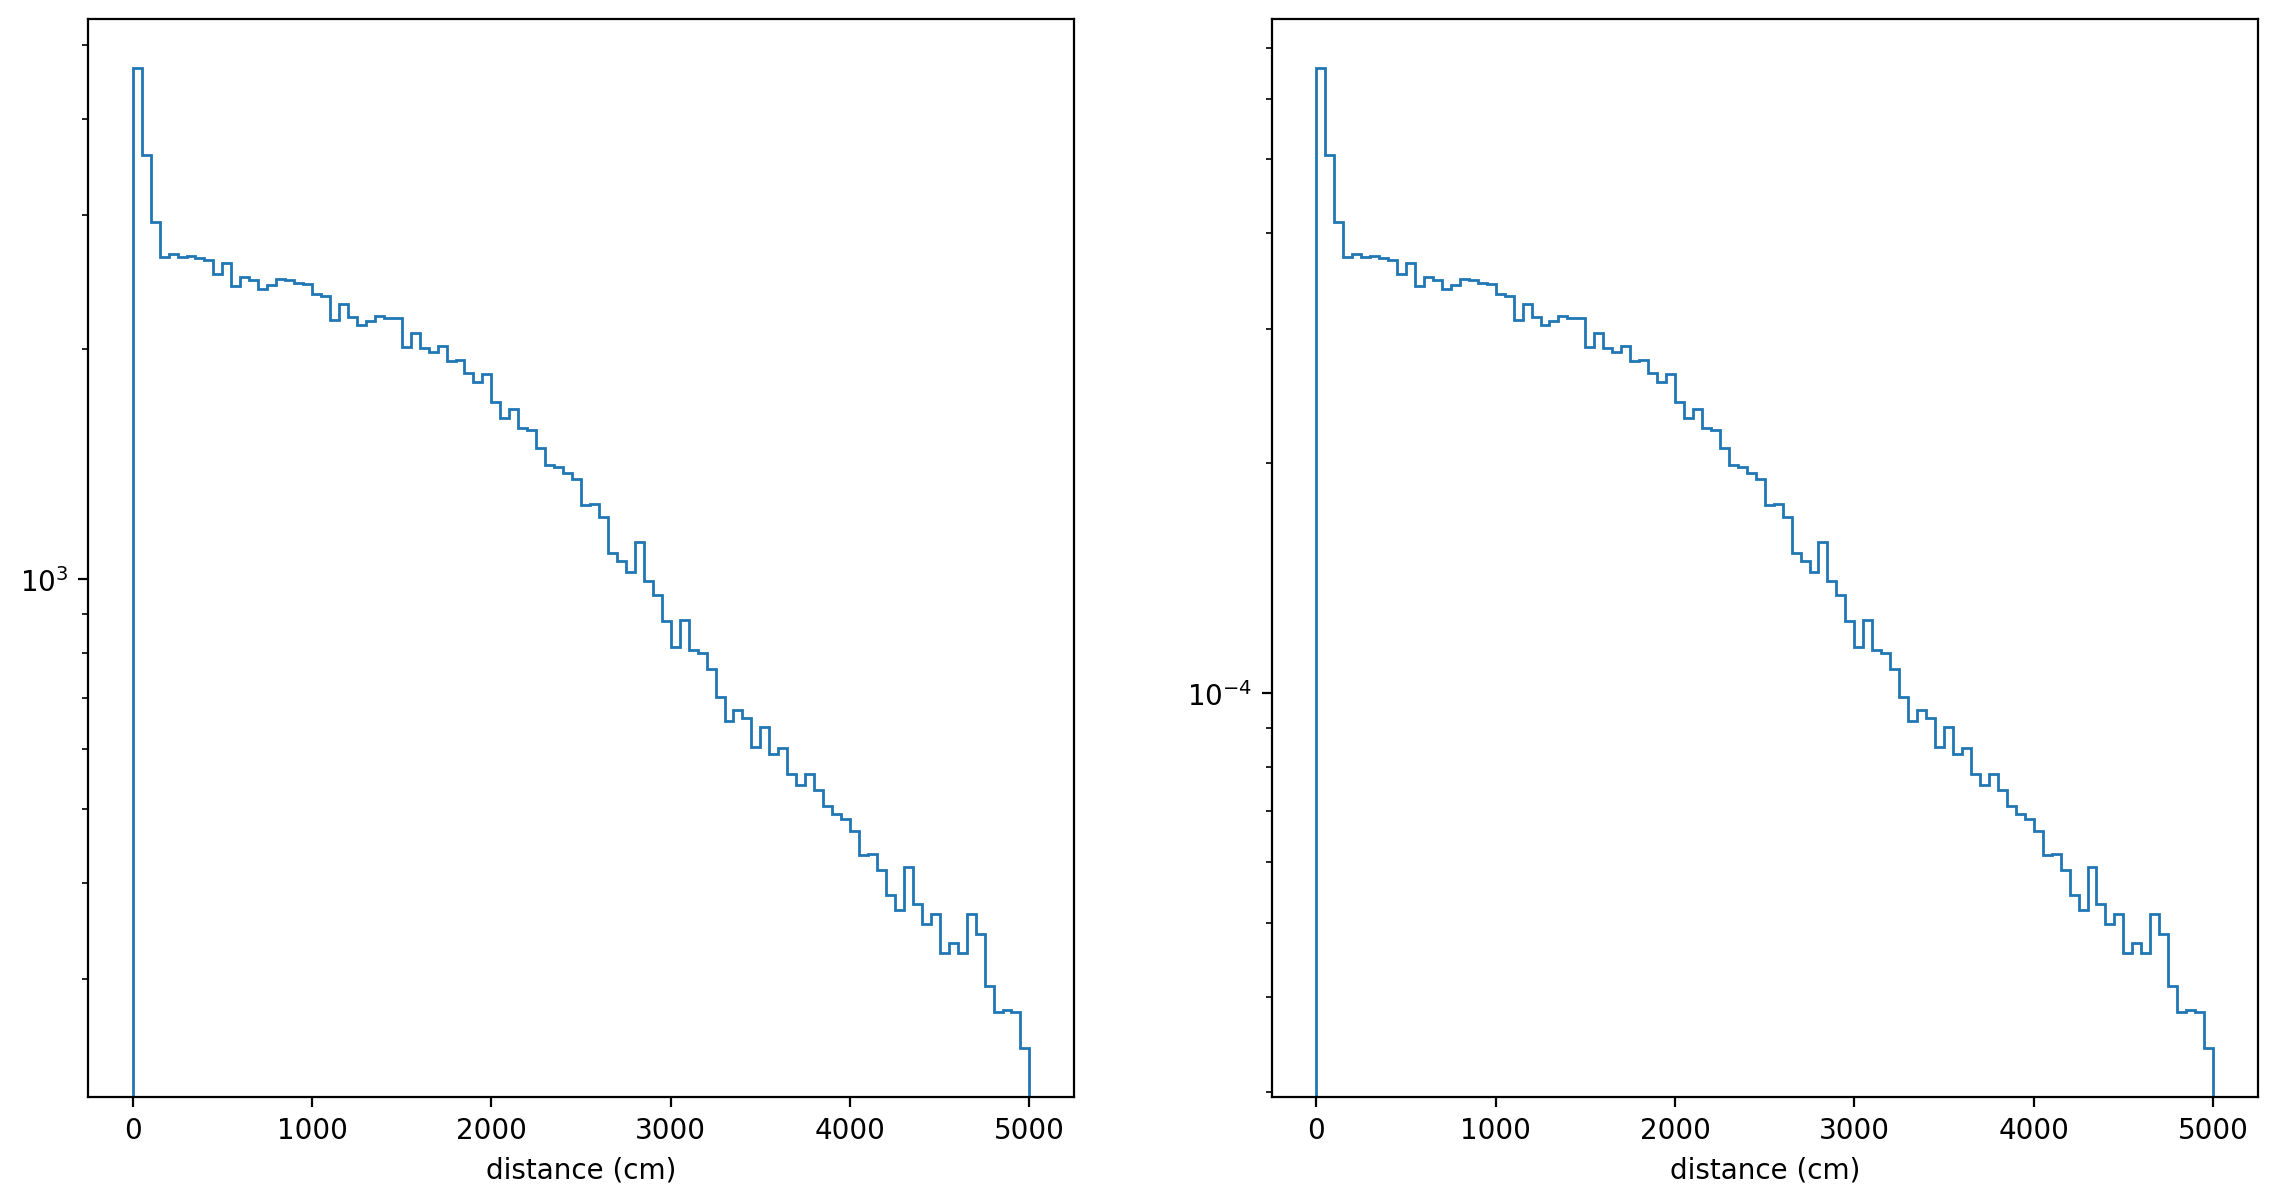

In [29]:
fig,axs=plt.subplots(1,2,figsize=(14,7))
axs=axs.flatten().tolist()

distancesCounts, distancesBins = np.histogram(distances, bins=100)

binsize = distancesBins[1] - distancesBins[0]
distancesNormed = distancesCounts/(sum(distancesCounts)*binsize)


axs[0].stairs(distancesCounts[:int(len(distancesCounts)/1)], distancesBins[:int(len(distancesCounts)/1) + 1])
axs[0].set_xlabel("distance (cm)")
axs[0].set_yscale("log")

axs[1].stairs(distancesNormed[:int(len(distancesCounts)/1)], distancesBins[:int(len(distancesCounts)/1) + 1])
axs[1].set_xlabel("distance (cm)")
axs[1].set_yscale("log")


## Chi2 and Distance Distribution (Event Level) ##

### Chi2 Distribution ### 

In [30]:
chi2s = []
distances = []
times = []
for f in pathList:
    events=joblib.load(f)
    file_hits = events["hits"]
    file_tracks = events["tracks"]
    file_vertices = events["vertices"]
    for i in range(len(file_hits)):
        hits= file_hits[i]
        tracks = file_tracks[i]
        vertices = file_vertices[i]
        if len(vertices) == 0:
            continue
        wf_hits = []
        for hit in hits:
            if hit.layer < 4:
                wf_hits.append(hit)
        if len(wf_hits) == 0:
            continue
        min_chi2 = None
        min_time = None
        min_distance = None
        for vertex in vertices:
            v_tracks = []
            for t_index in vertex.tracks:
                v_tracks.append(tracks[t_index])
            for track in v_tracks:
                for hit in wf_hits:
                    TrackPoints = SortByTime(track.hits_filtered)
                    tracklet = MakeTracklet(hit)
                    cur_chi2 = GetChiSquared(track, tracklet)
                    if cur_chi2 is not None and (min_chi2 is None or cur_chi2 < min_chi2):
                        min_chi2 = cur_chi2
                        min_time = TrackMinimumTime(track, tracklet)
                        min_distance = TrackDistance(track, tracklet, min_time)
        if min_chi2 is None:
            continue
        chi2_red = min_chi2
        if chi2_red > 0 and chi2_red < 200 and min_distance < 10000:
            chi2s.append(chi2_red)
            distances.append(min_distance)

[11.16424869]
[[1.12340423]]


Text(0, 0.5, 'Reduced chi2')

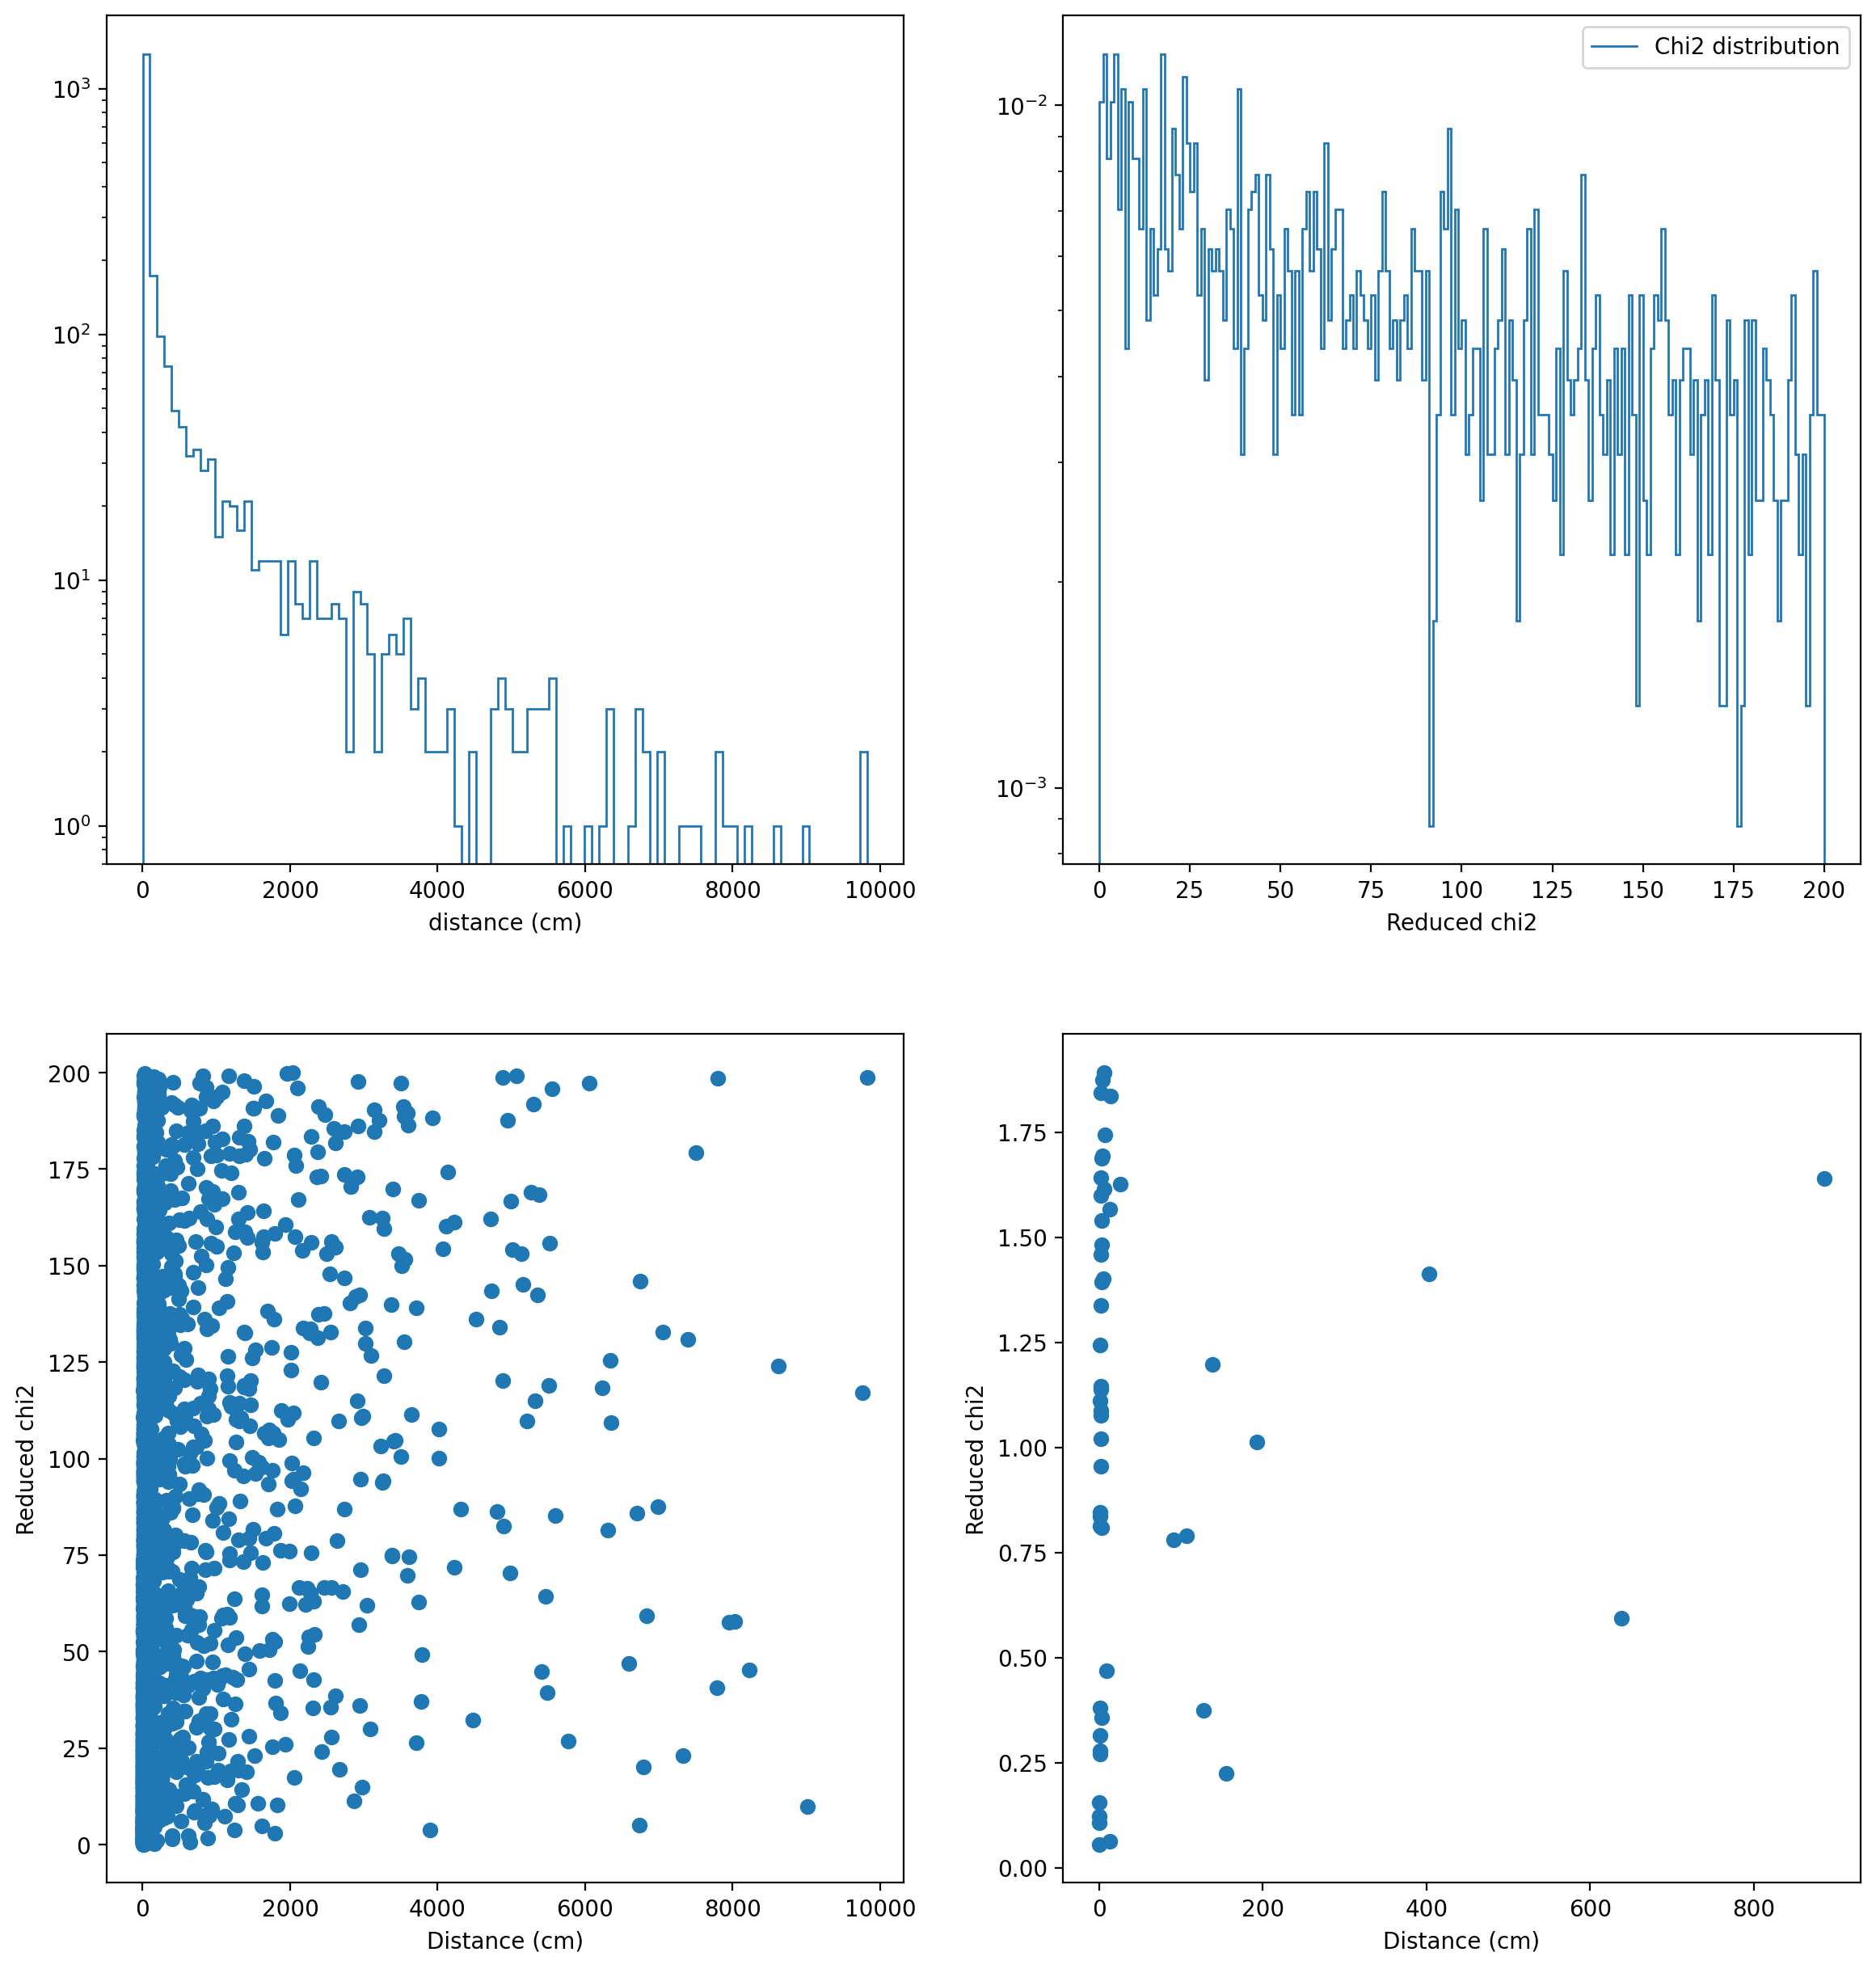

In [31]:
fig,axs=plt.subplots(2,2,figsize=(14,15))
axs=axs.flatten().tolist()

zoomedchis = []
zoomeddist = []
for i in range(len(chi2s)):
    if chi2s[i] < 2:
        zoomedchis.append(chi2s[i])
        zoomeddist.append(distances[i])

distancesCounts, distancesBins = np.histogram(distances, bins=100)
chi2Counts, chi2Bins = np.histogram(chi2s, bins=200)

binsize = chi2Bins[1] - chi2Bins[0]
chi2Counts = chi2Counts/(sum(chi2Counts)*binsize)

maxBin = 0
i=0
while chi2Bins[i] < 5:
    maxBin = i
    i+=1

popt, pcov = sp.optimize.curve_fit(lambda x,k: sp.stats.chi2.pdf(x,k,0,1), chi2Bins[:maxBin], chi2Counts[:maxBin], sigma=sqrt(chi2Counts[:maxBin]))
print(popt)
print(np.sqrt(pcov))

domain = np.arange(0, chi2Bins[-1], 0.1)
chi2_fit = sp.stats.chi2.pdf(domain, popt[0],0,1)
# chi2_fit = sp.stats.chi2.pdf(domain, 2,0,1)

axs[0].stairs(distancesCounts[:int(len(distancesCounts)/1)], distancesBins[:int(len(distancesCounts)/1) + 1])
axs[0].set_xlabel("distance (cm)")
axs[0].set_yscale("log")
axs[1].stairs(chi2Counts[:int(len(chi2Counts)/1)], chi2Bins[:int(len(chi2Counts)/1) + 1], label="Chi2 distribution")
# axs[1].plot(domain[:int(len(domain)/1)], chi2_fit[:int(len(domain)/1)], label="chi2 fit")
axs[1].set_yscale('log')
axs[1].legend()
axs[1].set_xlabel("Reduced chi2")
axs[2].scatter(distances, chi2s)
axs[2].set_xlabel("Distance (cm)")
axs[2].set_ylabel("Reduced chi2")
axs[3].scatter(zoomeddist, zoomedchis)
axs[3].set_xlabel("Distance (cm)")
axs[3].set_ylabel("Reduced chi2")

### Distance Distribution ###

In [32]:
distances = []
for f in pathList:
    events=joblib.load(f)
    file_hits = events["hits"]
    file_tracks = events["tracks"]
    file_vertices = events["vertices"]
    for i in range(len(file_hits)):
        hits= file_hits[i]
        tracks = file_tracks[i]
        vertices = file_vertices[i]
        if len(vertices) == 0:
            continue
        wf_hits = []
        for hit in hits:
            if hit.layer < 4:
                wf_hits.append(hit)
        if len(wf_hits) == 0:
            continue
        min_hit = None
        min_dist = None
        min_time = None
        min_point = None
        for vertex in vertices:
            v_tracks = []
            for t_index in vertex.tracks:
                v_tracks.append(tracks[t_index])
            for track in v_tracks:
                for hit in wf_hits:
                    tracklet = MakeTracklet(hit)
                    t_shortest = TrackMinimumTime(track, tracklet)
                    dist = TrackDistance(track, tracklet, t_shortest)
                    if min_dist is None or dist < min_dist:
                        min_dist = dist
        if min_dist is None:
            continue
        if dist > 0 and dist < 5000:
            distances.append(min_dist)

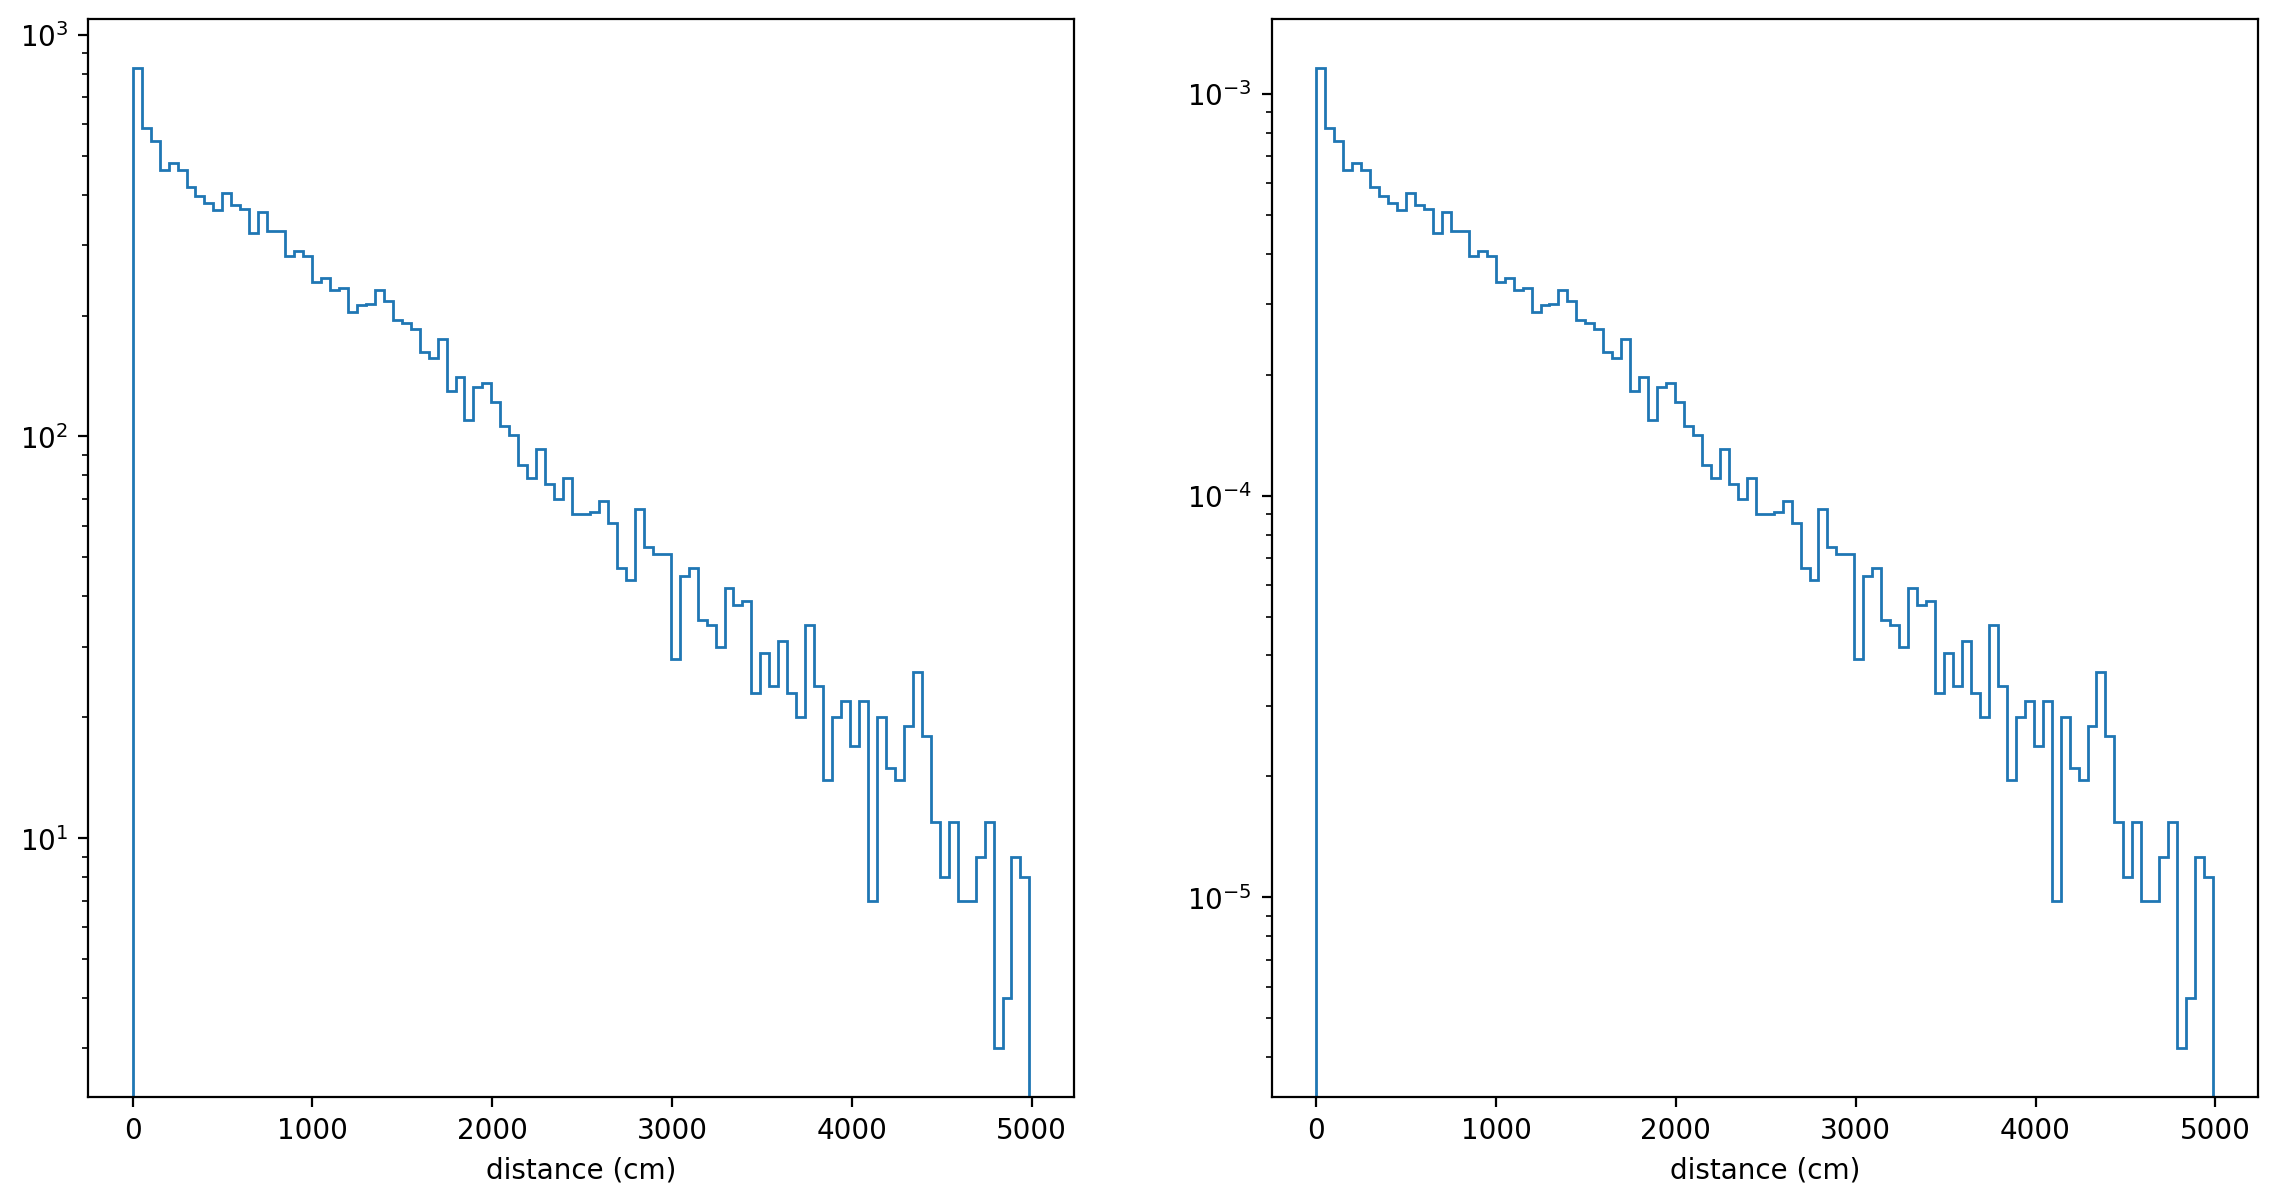

In [33]:
fig,axs=plt.subplots(1,2,figsize=(14,7))
axs=axs.flatten().tolist()

distancesCounts, distancesBins = np.histogram(distances, bins=100)

binsize = distancesBins[1] - distancesBins[0]
distancesNormed = distancesCounts/(sum(distancesCounts)*binsize)


axs[0].stairs(distancesCounts[:int(len(distancesCounts)/1)], distancesBins[:int(len(distancesCounts)/1) + 1])
axs[0].set_xlabel("distance (cm)")
axs[0].set_yscale("log")

axs[1].stairs(distancesNormed[:int(len(distancesCounts)/1)], distancesBins[:int(len(distancesCounts)/1) + 1])
axs[1].set_xlabel("distance (cm)")
axs[1].set_yscale("log")


## Implementing Veto: Track Veto Efficiency ##

### Survival Rate for given Distance Values ###

In [34]:
distances = []
nTracks = 0
for f in pathList:
    events=joblib.load(f)
    file_hits = events["hits"]
    file_tracks = events["tracks"]
    for i in range(len(file_hits)):
        hits= file_hits[i]
        tracks = file_tracks[i]
        nTracks += len(tracks)
        wf_hits = []
        for hit in hits:
            if hit.layer < 4:
                wf_hits.append(hit)
        if len(wf_hits) == 0:
            continue
        for track in tracks:
            min_hit = None
            min_dist = None
            min_time = None
            min_point = None
            for hit in wf_hits:
                tracklet = MakeTracklet(hit)
                t_shortest = TrackMinimumTime(track, tracklet)
                dist = TrackDistance(track, tracklet, t_shortest)
                if min_dist is None or dist < min_dist:
                    min_dist = dist
            if min_dist is None:
                continue
            if dist > 0 and dist < 5000:
                distances.append(min_dist)
                times.append(min_time)

Fraction surviving after dist=100 cut: 0.981723763757557
Fraction surviving after dist=200 cut: 0.9693801625440132
Fraction surviving after dist=300 cut: 0.9576322607790597
Fraction surviving after dist=500 cut: 0.9345660694908874


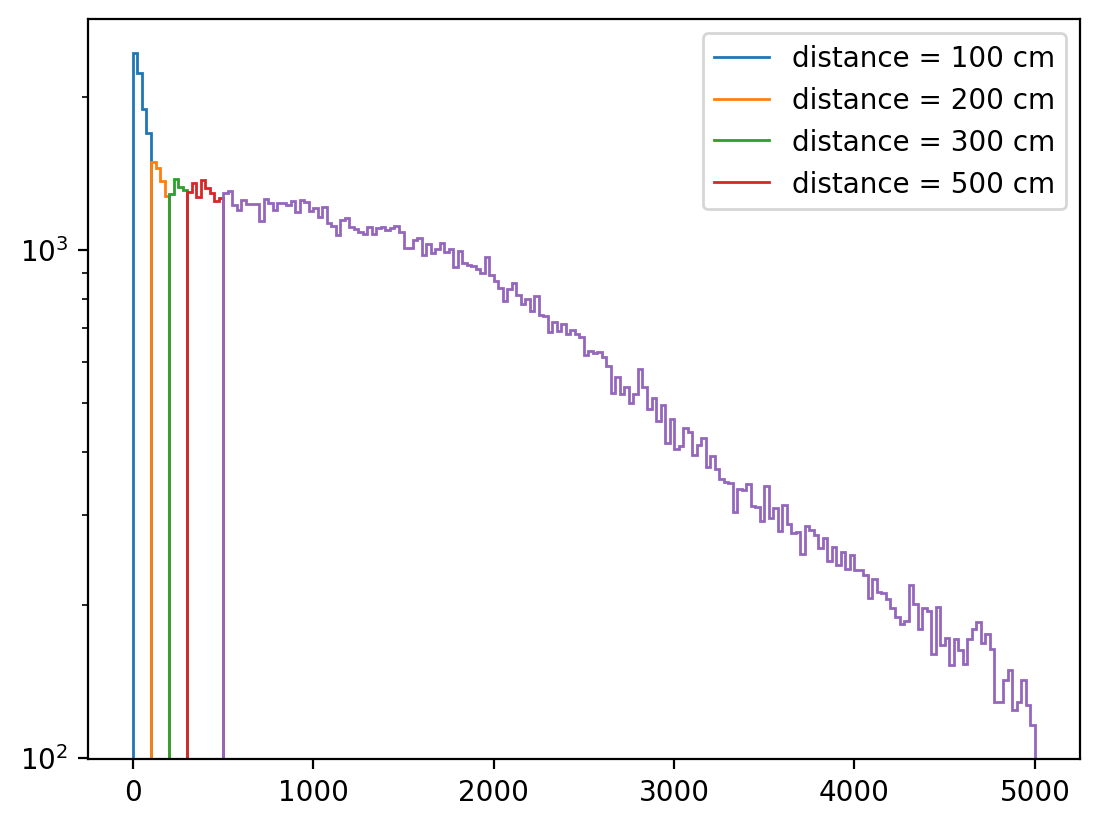

In [35]:
d_1Counts = []
d_2Counts = []
d_3Counts = []
d_5Counts = []
d_restCounts = []

dCounts, dBins = np.histogram(distances, bins=200)

i=0
start_1 = 0
while dBins[i] < 100:
    d_1Counts.append(dCounts[i])
    i+=1
n_1Bins = dBins[start_1:start_1 + len(d_1Counts)+1]
start_2 = i
while dBins[i] < 200:
    d_2Counts.append(dCounts[i])
    i+=1
n_2Bins = dBins[start_2:start_2 + len(d_2Counts)+1]
start_3 = i
while dBins[i] < 300:
    d_3Counts.append(dCounts[i])
    i+=1
n_3Bins = dBins[start_3:start_3 + len(d_3Counts)+1]
start_5 = i
while dBins[i] < 500:
    d_5Counts.append(dCounts[i])
    i+=1
n_5Bins = dBins[start_5:start_5 + len(d_5Counts)+1]
start_rest = i
while i < len(dBins) - 1:
    d_restCounts.append(dCounts[i])
    i+=1
n_rest = dBins[start_rest:start_rest + len(d_restCounts)+1]
frac_1 = 1 - sum(d_1Counts)/nTracks; frac_2 = 1 - (sum(d_1Counts) + sum(d_2Counts))/nTracks
frac_3 = 1 - (sum(d_1Counts) + sum(d_2Counts) + sum(d_3Counts))/nTracks
frac_5 = 1 - (sum(d_1Counts) + sum(d_2Counts) + sum(d_3Counts) + sum(d_5Counts))/nTracks
print("Fraction surviving after dist=100 cut:", frac_1)
print("Fraction surviving after dist=200 cut:", frac_2)
print("Fraction surviving after dist=300 cut:", frac_3)
print("Fraction surviving after dist=500 cut:", frac_5)
plt.stairs(d_1Counts, n_1Bins, label="distance = 100 cm")
plt.stairs(d_2Counts, n_2Bins, label="distance = 200 cm")
plt.stairs(d_3Counts, n_3Bins, label="distance = 300 cm")
plt.stairs(d_5Counts, n_5Bins, label="distance = 500 cm")
plt.stairs(d_restCounts, n_rest)
plt.yscale('log')
plt.legend()

## Implementing Veto: Event Veto Efficiency ##

### Survival Rate for given Distance Values ###

In [36]:
distances = []
nEvents = 0
for f in pathList:
    events=joblib.load(f)
    file_hits = events["hits"]
    file_tracks = events["tracks"]
    file_vertices = events["vertices"]
    for i in range(len(file_hits)):
        hits= file_hits[i]
        tracks = file_tracks[i]
        vertices = file_vertices[i]
        if len(vertices) == 0:
            continue
        nEvents += 1
        wf_hits = []
        for hit in hits:
            if hit.layer < 4:
                wf_hits.append(hit)
        if len(wf_hits) == 0:
            continue
        min_hit = None
        min_dist = None
        min_time = None
        min_point = None
        for vertex in vertices:
            v_tracks = []
            for t_index in vertex.tracks:
                v_tracks.append(tracks[t_index])
            for track in v_tracks:
                for hit in wf_hits:
                    tracklet = MakeTracklet(hit)
                    t_shortest = TrackMinimumTime(track, tracklet)
                    dist = TrackDistance(track, tracklet, t_shortest)
                    if min_dist is None or dist < min_dist:
                        min_dist = dist
        if min_dist is None:
            continue
        if dist > 0 and dist < 5000:
            distances.append(min_dist)
            times.append(min_time)

Fraction surviving after dist=100 cut: 0.9694711069702945
Fraction surviving after dist=200 cut: 0.9430372890169653
Fraction surviving after dist=300 cut: 0.922778584274045
Fraction surviving after dist=500 cut: 0.8892596364266678


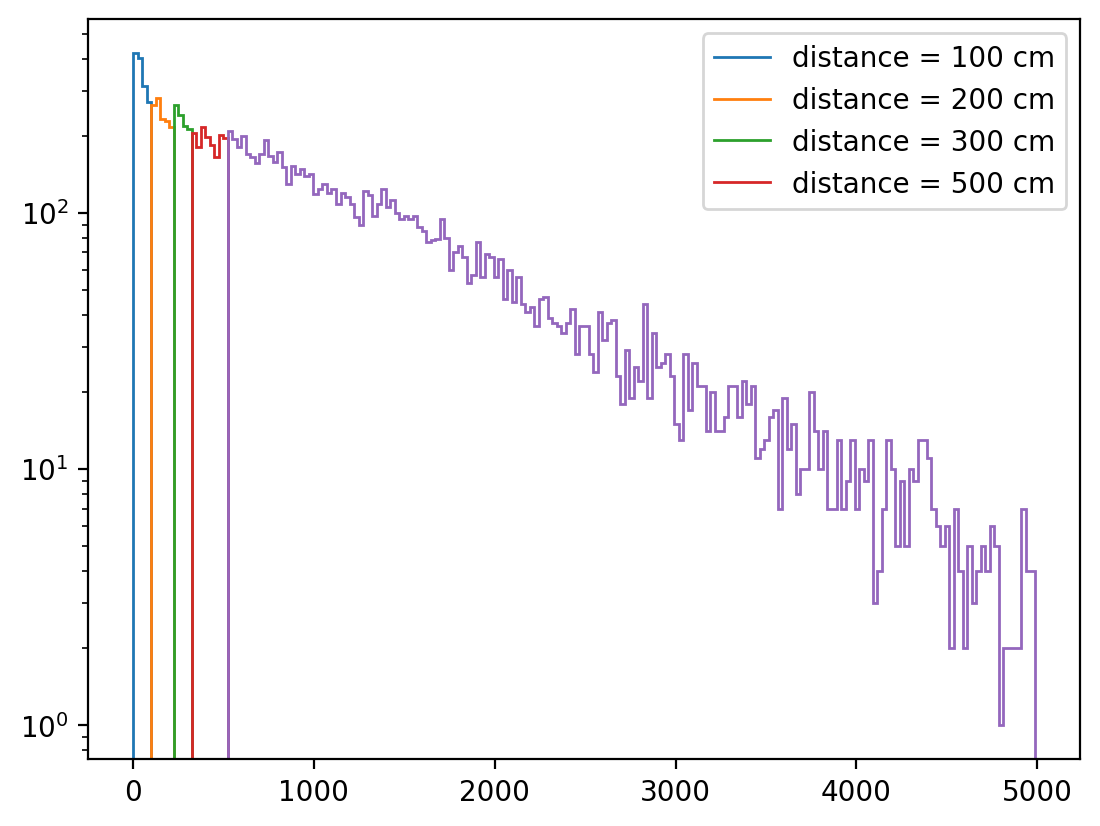

In [37]:
d_1Counts = []
d_2Counts = []
d_3Counts = []
d_5Counts = []
d_restCounts = []

dCounts, dBins = np.histogram(distances, bins=200)

i=0
start_1 = 0
while dBins[i] < 100:
    d_1Counts.append(dCounts[i])
    i+=1
n_1Bins = dBins[start_1:start_1 + len(d_1Counts)+1]
start_2 = i
while dBins[i] < 200:
    d_2Counts.append(dCounts[i])
    i+=1
n_2Bins = dBins[start_2:start_2 + len(d_2Counts)+1]
start_3 = i
while dBins[i] < 300:
    d_3Counts.append(dCounts[i])
    i+=1
n_3Bins = dBins[start_3:start_3 + len(d_3Counts)+1]
start_5 = i
while dBins[i] < 500:
    d_5Counts.append(dCounts[i])
    i+=1
n_5Bins = dBins[start_5:start_5 + len(d_5Counts)+1]
start_rest = i
while i < len(dBins) - 1:
    d_restCounts.append(dCounts[i])
    i+=1
n_rest = dBins[start_rest:start_rest + len(d_restCounts)+1]
frac_1 = 1 - sum(d_1Counts)/nEvents; frac_2 = 1 - (sum(d_1Counts) + sum(d_2Counts))/nEvents
frac_3 = 1 - (sum(d_1Counts) + sum(d_2Counts) + sum(d_3Counts))/nEvents
frac_5 = 1 - (sum(d_1Counts) + sum(d_2Counts) + sum(d_3Counts) + sum(d_5Counts))/nEvents
print("Fraction surviving after dist=100 cut:", frac_1)
print("Fraction surviving after dist=200 cut:", frac_2)
print("Fraction surviving after dist=300 cut:", frac_3)
print("Fraction surviving after dist=500 cut:", frac_5)
plt.stairs(d_1Counts, n_1Bins, label="distance = 100 cm")
plt.stairs(d_2Counts, n_2Bins, label="distance = 200 cm")
plt.stairs(d_3Counts, n_3Bins, label="distance = 300 cm")
plt.stairs(d_5Counts, n_5Bins, label="distance = 500 cm")
plt.stairs(d_restCounts, n_rest)
plt.yscale('log')
plt.legend()